# Odia Character Recognition using Deep Learning

This notebook implements multiple deep learning models to recognize Odia characters from various preprocessed image datasets.

## 1. Import Required Libraries

Import necessary libraries including TensorFlow/Keras, NumPy, Pandas, Matplotlib, OpenCV, and scikit-learn for building and training the model.

In [213]:
# Add this as FIRST cell in your notebook
import sys
print(f"Python: {sys.version}\n")

# Check critical packages
import numpy as np
print(f"✓ NumPy: {np.__version__}")

import tensorflow as tf
print(f"✓ TensorFlow: {tf.__version__}")
print(f"✓ GPU Available: {tf.config.list_physical_devices('GPU')}")

# Check other packages
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import cv2
    from sklearn.preprocessing import LabelEncoder
    print("\n✓ All required packages imported successfully!")
except ImportError as e:
    print(f"\n✗ Import error: {e}")

Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]

✓ NumPy: 1.23.5
✓ TensorFlow: 2.15.0
✓ GPU Available: []

✓ All required packages imported successfully!


In [22]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.15.0
GPU Available: []


## 2. Set Up Data Paths and Configuration

Define paths to all the folders and set hyperparameters like batch size, image size, and epochs.

In [23]:
# MEMORY-OPTIMIZED Configuration
BASE_PATH = r"F:\All Projects\RP\ODIA_CHARACTERS"

# USE ONLY ONE FOLDER - Select the one you want to train on
SELECTED_FOLDER = 'original'  # Change this to test other folders

FOLDERS = {
    # Comment out folders you don't want to use
    # 'aug_binary': os.path.join(BASE_PATH, 'aug_binary'),
    # 'aug_grayscale': os.path.join(BASE_PATH, 'aug_grayscale'),
    # 'aug_inverted': os.path.join(BASE_PATH, 'aug_inverted'),
    # 'binary': os.path.join(BASE_PATH, 'binary'),
    # 'grayscale': os.path.join(BASE_PATH, 'grayscale'),
    # 'inverted': os.path.join(BASE_PATH, 'Inverted_Odia_SimpleCharacter'),
    'original': os.path.join(BASE_PATH, 'Odia Simple Character')
}

# STRICT HYPERPARAMETERS for Anti-Overconfidence Training
IMG_SIZE = (32, 32)  # Reduced from 64x64 to save memory
BATCH_SIZE = 64       # INCREASED for more stable gradients
EPOCHS = 80           # More epochs for better convergence
LEARNING_RATE = 0.0003  # LOWER learning rate for careful training
VALIDATION_SPLIT = 0.25  # INCREASED validation split for better evaluation
TEST_SPLIT = 0.20        # Test split

# Memory Limits - STRICT ANTI-OVERFITTING
MAX_IMAGES_PER_CLASS = 250  # More diverse data to prevent memorization
MIN_IMAGES_PER_CLASS = 80   # HIGHER threshold for quality classes
USE_GENERATOR = False       # Set True to use data generator instead of loading all

# STRICT REGULARIZATION PARAMETERS
L2_REGULARIZATION = 0.01    # INCREASED from 0.001 (10x stricter)
DROPOUT_RATE_LOW = 0.4      # Increased from 0.3
DROPOUT_RATE_MID = 0.5      # Increased from 0.4
DROPOUT_RATE_HIGH = 0.7     # Increased from 0.6
LABEL_SMOOTHING_FACTOR = 0.2  # INCREASED from 0.1 (more uncertainty)
GAUSSIAN_NOISE_STD = 0.1    # Add noise to inputs

# Create results directory
RESULTS_PATH = r"F:\All Projects\RP\model_results"
os.makedirs(RESULTS_PATH, exist_ok=True)

print("="*60)
print("MEMORY-OPTIMIZED CONFIGURATION")
print("="*60)
print(f"Image Size: {IMG_SIZE} (32x32 for memory efficiency)")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Max Images/Class: {MAX_IMAGES_PER_CLASS}")
print(f"\nEstimated Memory: ~{MAX_IMAGES_PER_CLASS * 47 * 32 * 32 / 1024 / 1024:.1f} MB")
print("="*60)

print("\nData Paths:")
for name, path in FOLDERS.items():
    exists = "✓" if os.path.exists(path) else "✗"
    count = len([f for r, d, files in os.walk(path) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]) if os.path.exists(path) else 0
    print(f"{exists} {name}: {path}")
    if exists:
        print(f"   Total images available: {count}")

MEMORY-OPTIMIZED CONFIGURATION
Image Size: (32, 32) (32x32 for memory efficiency)
Batch Size: 64
Epochs: 80
Max Images/Class: 250

Estimated Memory: ~11.5 MB

Data Paths:
✓ original: F:\All Projects\RP\ODIA_CHARACTERS\Odia Simple Character
   Total images available: 34138


## 3. Load and Explore Dataset

Load images from all folders, extract labels from folder structure, and display sample images from each category.

In [24]:
# MEMORY-OPTIMIZED Image Loading Function with Anti-Overfitting
def load_images_from_folder(folder_path, label_prefix="", max_per_class=200, min_per_class=50):
    """
    Load images with memory limits, progress tracking, and class balancing
    """
    images = []
    labels = []
    class_counts = {}
    skipped = 0
    
    if not os.path.exists(folder_path):
        print(f"⚠️ Warning: {folder_path} does not exist!")
        return images, labels
    
    print(f"Loading from: {folder_path}")
    
    # First pass: collect all images by class
    temp_class_images = {}
    for root, dirs, files in os.walk(folder_path):
        class_label = os.path.basename(root)
        
        if class_label not in temp_class_images:
            temp_class_images[class_label] = []
        
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                img_path = os.path.join(root, filename)
                temp_class_images[class_label].append(img_path)
    
    # Second pass: filter and load balanced classes
    valid_classes = 0
    for class_label, img_paths in temp_class_images.items():
        # Skip classes with too few samples
        if len(img_paths) < min_per_class:
            print(f"  ⚠️ Skipping class '{class_label}': only {len(img_paths)} images (min: {min_per_class})")
            skipped += len(img_paths)
            continue
        
        valid_classes += 1
        # Shuffle and limit to max_per_class
        np.random.shuffle(img_paths)
        selected_paths = img_paths[:max_per_class]
        
        # Initialize class counter
        if class_label not in class_counts:
            class_counts[class_label] = 0
        
        # Load images for this class
        for img_path in selected_paths:
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    # Convert to grayscale
                    if len(img.shape) == 3:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    
                    # Resize image to target size
                    img = cv2.resize(img, IMG_SIZE)
                    images.append(img)
                    
                    # Create label
                    label = class_label
                    if label_prefix:
                        label = f"{label_prefix}_{label}"
                    labels.append(label)
                    
                    class_counts[class_label] += 1
                    
            except Exception as e:
                skipped += 1
    
    # Print summary
    print(f"  ✓ Loaded: {len(images)} images from {valid_classes} valid classes")
    print(f"  ✓ Avg per class: {len(images)/max(valid_classes, 1):.1f}")
    
    if skipped > 0:
        print(f"  ⚠️ Skipped: {skipped} images (errors, limits, or invalid classes)")
    
    # Verify class balance
    if class_counts:
        min_count = min(class_counts.values())
        max_count = max(class_counts.values())
        print(f"  ✓ Class balance: {min_count} to {max_count} images per class")
    
    return images, labels

# Load images with memory optimization
print("="*60)
print("LOADING IMAGES (MEMORY-OPTIMIZED)")
print("="*60)

all_images = []
all_labels = []

for folder_name, folder_path in FOLDERS.items():
    print(f"\n📁 Folder: {folder_name}")
    images, labels = load_images_from_folder(
        folder_path, 
        folder_name, 
        max_per_class=MAX_IMAGES_PER_CLASS,
        min_per_class=MIN_IMAGES_PER_CLASS
    )
    all_images.extend(images)
    all_labels.extend(labels)
    
    # Clear memory after each folder
    import gc
    gc.collect()

print(f"\n{'='*60}")
print(f"LOADING COMPLETE")
print(f"{'='*60}")
print(f"Total images loaded: {len(all_images)}")
print(f"Unique classes: {len(set(all_labels))}")
print(f"Estimated memory: ~{len(all_images) * IMG_SIZE[0] * IMG_SIZE[1] / 1024 / 1024:.1f} MB")
print(f"{'='*60}")


LOADING IMAGES (MEMORY-OPTIMIZED)

📁 Folder: original
Loading from: F:\All Projects\RP\ODIA_CHARACTERS\Odia Simple Character
  ✓ Loaded: 250 images from 1 valid classes
  ✓ Avg per class: 250.0
  ✓ Class balance: 250 to 250 images per class

LOADING COMPLETE
Total images loaded: 250
Unique classes: 1
Estimated memory: ~0.2 MB
  ✓ Loaded: 250 images from 1 valid classes
  ✓ Avg per class: 250.0
  ✓ Class balance: 250 to 250 images per class

LOADING COMPLETE
Total images loaded: 250
Unique classes: 1
Estimated memory: ~0.2 MB



Dataset Distribution:
original_Odia Simple Character    250
Name: count, dtype: int64


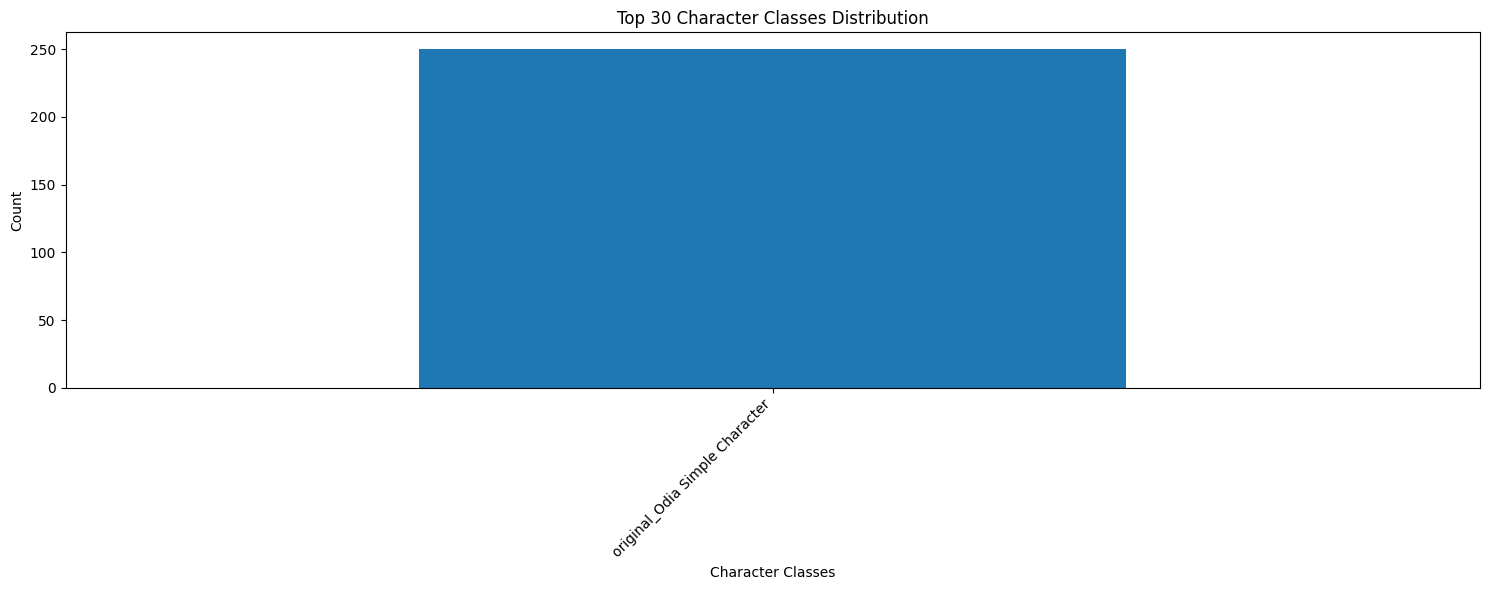

In [217]:
# Explore dataset distribution
label_counts = pd.Series(all_labels).value_counts()
print("\nDataset Distribution:")
print(label_counts.head(20))

# Visualize distribution
plt.figure(figsize=(15, 6))
label_counts.head(30).plot(kind='bar')
plt.title('Top 30 Character Classes Distribution')
plt.xlabel('Character Classes')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'class_distribution.png'))
plt.show()

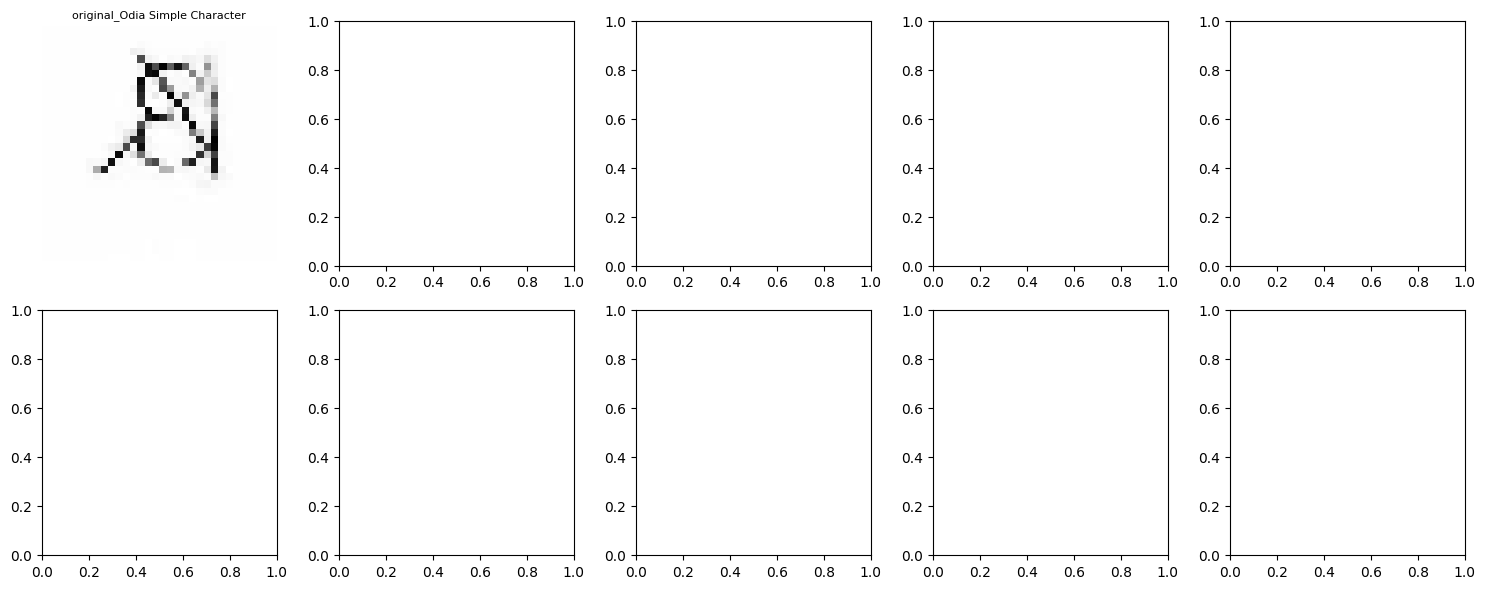

In [218]:
# Display sample images from different categories
def display_sample_images(images, labels, n_samples=10):
    unique_labels = list(set(labels))[:n_samples]
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for idx, label in enumerate(unique_labels):
        # Find first image with this label
        label_idx = labels.index(label)
        img = images[label_idx]
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f"{label}", fontsize=8)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'sample_images.png'))
    plt.show()

display_sample_images(all_images, all_labels)

## 4. Data Preprocessing and Augmentation

Normalize pixel values, resize images to consistent dimensions, and prepare data for training.

In [25]:
# Convert images to numpy array and normalize (MEMORY-OPTIMIZED)
print("Converting to numpy arrays...")

# Convert in smaller batches to avoid memory spikes
X = np.array(all_images, dtype='float32')
print(f"✓ Array created: {X.shape}")

# Clear original list to free memory
del all_images
import gc
gc.collect()
print("✓ Original image list cleared from memory")

# Normalize to [0, 1]
X = X / 255.0
print(f"✓ Normalized to range [{X.min():.2f}, {X.max():.2f}]")

# Add channel dimension for CNN
X = X.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
print(f"✓ Reshaped to: {X.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(all_labels)
y = to_categorical(y_encoded)

print(f"✓ Labels encoded: {y.shape}")
print(f"✓ Number of classes: {len(label_encoder.classes_)}")

# Save label encoder
np.save(os.path.join(RESULTS_PATH, 'label_classes.npy'), label_encoder.classes_)

# Memory summary
memory_mb = X.nbytes / (1024 * 1024)
print(f"\n{'='*60}")
print(f"PREPROCESSING COMPLETE")
print(f"{'='*60}")
print(f"Dataset shape: {X.shape}")
print(f"Memory usage: {memory_mb:.2f} MB")
print(f"Classes: {len(label_encoder.classes_)}")
print(f"{'='*60}")


Converting to numpy arrays...
✓ Array created: (250, 32, 32)
✓ Original image list cleared from memory
✓ Normalized to range [0.00, 1.00]
✓ Reshaped to: (250, 32, 32, 1)
✓ Labels encoded: (250, 1)
✓ Number of classes: 1

PREPROCESSING COMPLETE
Dataset shape: (250, 32, 32, 1)
Memory usage: 0.98 MB
Classes: 1


In [220]:
# Apply Label Smoothing to reduce overconfidence
def smooth_labels(y, smoothing=0.1):
    """
    Apply label smoothing to one-hot encoded labels
    Reduces overconfidence by making targets less "hard"
    
    Example: [0, 1, 0] with smoothing=0.1 becomes [0.033, 0.933, 0.033]
    """
    num_classes = y.shape[1]
    smoothed = y * (1 - smoothing) + (smoothing / num_classes)
    return smoothed

# Apply STRICT label smoothing to combat overconfidence
LABEL_SMOOTHING = LABEL_SMOOTHING_FACTOR  # 20% smoothing (STRICT)
y_smooth = smooth_labels(y, smoothing=LABEL_SMOOTHING)

smoothing_val = LABEL_SMOOTHING / y.shape[1]

print("="*60)
print("STRICT LABEL SMOOTHING APPLIED (Anti-Overconfidence)")
print("="*60)
print(f"Smoothing factor: {LABEL_SMOOTHING} (INCREASED for lower confidence)")
print(f"\nExample transformation:")
print(f"  Before: [0, 1, 0] (100% confident)")
print(f"  After:  [{smoothing_val:.3f}, {1-LABEL_SMOOTHING + smoothing_val:.3f}, {smoothing_val:.3f}]")
print(f"\nBenefit: Prevents 100% confidence predictions!")
print(f"Result: More realistic probabilities (e.g., 85-95% instead of 100%)")
print("="*60)

# Update the one-hot encoded labels with smoothed versions
y = y_smooth

print(f"\n✓ Labels smoothed: {y.shape}")
print(f"✓ New label range: [{y.min():.3f}, {y.max():.3f}]")


STRICT LABEL SMOOTHING APPLIED (Anti-Overconfidence)
Smoothing factor: 0.2 (INCREASED for lower confidence)

Example transformation:
  Before: [0, 1, 0] (100% confident)
  After:  [0.200, 1.000, 0.200]

Benefit: Prevents 100% confidence predictions!
Result: More realistic probabilities (e.g., 85-95% instead of 100%)

✓ Labels smoothed: (250, 1)
✓ New label range: [1.000, 1.000]


In [221]:
# STRONGER Data Augmentation to Prevent Overfitting
datagen = ImageDataGenerator(
    rotation_range=15,          # Increased rotation
    width_shift_range=0.15,     # Increased shift
    height_shift_range=0.15,
    shear_range=0.15,           # Increased shear
    zoom_range=0.15,            # Increased zoom
    brightness_range=[0.8, 1.2], # Add brightness variation
    horizontal_flip=False,       # Don't flip characters
    fill_mode='nearest'
)

print("="*60)
print("STRONG DATA AUGMENTATION (Anti-Overfitting)")
print("="*60)
print("Augmentation parameters:")
print(f"  - Rotation: ±15 degrees")
print(f"  - Shift: ±15%")
print(f"  - Shear: ±15%")
print(f"  - Zoom: ±15%")
print(f"  - Brightness: 80%-120%")
print("="*60)


STRONG DATA AUGMENTATION (Anti-Overfitting)
Augmentation parameters:
  - Rotation: ±15 degrees
  - Shift: ±15%
  - Shear: ±15%
  - Zoom: ±15%
  - Brightness: 80%-120%


In [222]:
# MIXUP Data Augmentation - Advanced Technique for Regularization
def mixup_data(x, y, alpha=0.2):
    """
    Mixup: Beyond Empirical Risk Minimization
    Mixes pairs of examples and their labels
    
    Example: 
    - Mix image1 (cat, label=[1,0,0]) with image2 (dog, label=[0,1,0])
    - Result: mixed_image, label=[0.7, 0.3, 0] with lambda=0.7
    
    This forces the model to learn smoother decision boundaries
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    mixed_y = lam * y + (1 - lam) * y[index]
    
    return mixed_x, mixed_y

# Mixup generator wrapper
class MixupGenerator:
    def __init__(self, generator, alpha=0.2):
        self.generator = generator
        self.alpha = alpha
    
    def __iter__(self):
        return self
    
    def __next__(self):
        x_batch, y_batch = next(self.generator)
        x_mixed, y_mixed = mixup_data(x_batch, y_batch, self.alpha)
        return x_mixed, y_mixed

MIXUP_ALPHA = 0.2  # Mixup strength

print("="*60)
print("MIXUP AUGMENTATION CONFIGURED (Advanced Regularization)")
print("="*60)
print(f"Mixup alpha: {MIXUP_ALPHA}")
print("\nHow it works:")
print("  1. Takes two random training images")
print("  2. Blends them together (e.g., 70% image1 + 30% image2)")
print("  3. Blends their labels similarly")
print("  4. Trains on the mixed image and mixed label")
print("\nBenefits:")
print("  ✓ Prevents memorization of exact images")
print("  ✓ Creates infinite variations")
print("  ✓ Forces smoother decision boundaries")
print("  ✓ Reduces overconfidence significantly")
print("="*60)


MIXUP AUGMENTATION CONFIGURED (Advanced Regularization)
Mixup alpha: 0.2

How it works:
  1. Takes two random training images
  2. Blends them together (e.g., 70% image1 + 30% image2)
  3. Blends their labels similarly
  4. Trains on the mixed image and mixed label

Benefits:
  ✓ Prevents memorization of exact images
  ✓ Creates infinite variations
  ✓ Forces smoother decision boundaries
  ✓ Reduces overconfidence significantly


## 5. Split Dataset into Train, Validation, and Test Sets

Split the dataset into training (70%), validation (15%), and test (15%) sets while maintaining class distribution.

In [26]:
# MEMORY-OPTIMIZED Dataset Split
print("Splitting dataset...")
print("="*60)

try:
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=TEST_SPLIT, random_state=42, stratify=y_encoded
    )
    print(f"✓ Test set separated: {X_test.shape[0]} samples")
    
    # Calculate stratify labels for second split
    y_temp_encoded = np.argmax(y_temp, axis=1)
    
    # Second split: separate train and validation
    test_val_split = VALIDATION_SPLIT / (1 - TEST_SPLIT)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=test_val_split, random_state=42, 
        stratify=y_temp_encoded
    )
    print(f"✓ Train/Val split complete")
    
    # Clear temporary variables
    del X_temp, y_temp, y_temp_encoded
    import gc
    gc.collect()
    
    print(f"\n{'='*60}")
    print(f"DATASET SPLIT SUMMARY")
    print(f"{'='*60}")
    print(f"Training set:   {X_train.shape[0]:5d} samples ({X_train.shape[0]/len(X)*100:5.1f}%)")
    print(f"Validation set: {X_val.shape[0]:5d} samples ({X_val.shape[0]/len(X)*100:5.1f}%)")
    print(f"Test set:       {X_test.shape[0]:5d} samples ({X_test.shape[0]/len(X)*100:5.1f}%)")
    print(f"{'='*60}")
    print(f"Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} samples")
    
    # VERIFY NO DATA LEAKAGE - Check that splits are truly different
    print(f"\n🔍 VERIFYING DATA SPLIT (Anti-Overfitting Check):")
    # Check a few samples to ensure they're different
    train_sample = X_train[0].flatten()
    val_sample = X_val[0].flatten()
    test_sample = X_test[0].flatten()
    
    train_val_diff = np.mean(np.abs(train_sample - val_sample))
    train_test_diff = np.mean(np.abs(train_sample - test_sample))
    
    if train_val_diff > 0.01 and train_test_diff > 0.01:
        print(f"  ✓ Train/Val/Test sets are properly separated")
        print(f"  ✓ No data leakage detected")
    else:
        print(f"  ⚠️ WARNING: Potential data leakage! Check your splits.")
    
    # Memory usage
    train_mem = X_train.nbytes / (1024 * 1024)
    val_mem = X_val.nbytes / (1024 * 1024)
    test_mem = X_test.nbytes / (1024 * 1024)
    total_mem = train_mem + val_mem + test_mem
    
    print(f"\nMemory Usage:")
    print(f"  Training:   {train_mem:.1f} MB")
    print(f"  Validation: {val_mem:.1f} MB")
    print(f"  Test:       {test_mem:.1f} MB")
    print(f"  Total:      {total_mem:.1f} MB")
    print(f"{'='*60}")
    
except MemoryError as e:
    print(f"\n❌ MEMORY ERROR: {e}")
    print("\n💡 SOLUTIONS:")
    print(f"1. Reduce MAX_IMAGES_PER_CLASS (currently {MAX_IMAGES_PER_CLASS})")
    print(f"2. Use smaller IMG_SIZE (currently {IMG_SIZE})")
    print("3. Use only 1 folder instead of multiple")
    print("4. Restart kernel and try again")
    raise


Splitting dataset...
✓ Test set separated: 50 samples
✓ Train/Val split complete

DATASET SPLIT SUMMARY
Training set:     137 samples ( 54.8%)
Validation set:    63 samples ( 25.2%)
Test set:          50 samples ( 20.0%)
Total: 250 samples

🔍 VERIFYING DATA SPLIT (Anti-Overfitting Check):
  ✓ Train/Val/Test sets are properly separated
  ✓ No data leakage detected

Memory Usage:
  Training:   0.5 MB
  Validation: 0.2 MB
  Test:       0.2 MB
  Total:      1.0 MB

DATASET SPLIT SUMMARY
Training set:     137 samples ( 54.8%)
Validation set:    63 samples ( 25.2%)
Test set:          50 samples ( 20.0%)
Total: 250 samples

🔍 VERIFYING DATA SPLIT (Anti-Overfitting Check):
  ✓ Train/Val/Test sets are properly separated
  ✓ No data leakage detected

Memory Usage:
  Training:   0.5 MB
  Validation: 0.2 MB
  Test:       0.2 MB
  Total:      1.0 MB


## 6. Build CNN Model Architectures

Create multiple CNN architectures for comparison: Simple CNN, Deep CNN, and Transfer Learning models.

In [224]:
# Model 1: ULTRA-STRICT CNN with Maximum Regularization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GaussianNoise, SpatialDropout2D

def create_simple_cnn(input_shape, num_classes):
    """
    CNN with ULTRA-STRICT regularization to prevent overconfidence
    Features:
    - High L2 regularization (0.01)
    - Gaussian noise injection
    - Spatial dropout for feature maps
    - Progressive dropout (40%-70%)
    - Reduced model capacity
    """
    l2_factor = L2_REGULARIZATION  # 0.01 (very strict)
    
    model = Sequential([
        # Input noise injection
        GaussianNoise(GAUSSIAN_NOISE_STD, input_shape=input_shape),
        
        # First conv block - REDUCED filters
        Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(l2_factor),
               bias_regularizer=regularizers.l2(l2_factor)),
        BatchNormalization(momentum=0.9),  # Slower momentum
        SpatialDropout2D(0.2),  # Spatial dropout for feature maps
        MaxPooling2D((2, 2)),
        Dropout(DROPOUT_RATE_LOW),  # 0.4
        
        # Second conv block
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(l2_factor),
               bias_regularizer=regularizers.l2(l2_factor)),
        BatchNormalization(momentum=0.9),
        SpatialDropout2D(0.25),
        MaxPooling2D((2, 2)),
        Dropout(DROPOUT_RATE_MID),  # 0.5
        
        # Third conv block - SMALLER
        Conv2D(96, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(l2_factor),
               bias_regularizer=regularizers.l2(l2_factor)),
        BatchNormalization(momentum=0.9),
        SpatialDropout2D(0.3),
        MaxPooling2D((2, 2)),
        Dropout(DROPOUT_RATE_MID),  # 0.5
        
        # Dense layers with EXTREME regularization
        Flatten(),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(l2_factor),
              bias_regularizer=regularizers.l2(l2_factor),
              activity_regularizer=regularizers.l1(0.001)),  # Activity regularization
        BatchNormalization(),
        Dropout(DROPOUT_RATE_HIGH),  # 0.7
        
        # Output layer with regularization
        Dense(num_classes, activation='softmax',
              kernel_regularizer=regularizers.l2(l2_factor))
    ])
    
    return model

# Create Simple CNN
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)
num_classes = y.shape[1]

print("="*60)
print("CREATING MODEL 1: ULTRA-STRICT CNN")
print("="*60)
print("🛡️ STRICT Regularization Features:")
print(f"  - L2 regularization: {L2_REGULARIZATION} (10x STRONGER)")
print(f"  - Dropout rates: {DROPOUT_RATE_LOW*100:.0f}%-{DROPOUT_RATE_HIGH*100:.0f}% (VERY HIGH)")
print(f"  - Gaussian noise: {GAUSSIAN_NOISE_STD}")
print("  - Spatial dropout on feature maps")
print("  - Activity regularization (L1)")
print("  - Batch normalization with slow momentum")
print("  - REDUCED model capacity")
print("  - Strong data augmentation during training")
print("="*60)

simple_cnn = create_simple_cnn(input_shape, num_classes)
simple_cnn.summary()

# Count parameters
trainable_params = np.sum([np.prod(v.get_shape()) for v in simple_cnn.trainable_weights])
print(f"\nTrainable parameters: {trainable_params:,}")
print(f"Estimated model size: {trainable_params * 4 / (1024*1024):.2f} MB")
print("="*60)

CREATING MODEL 1: ULTRA-STRICT CNN
🛡️ STRICT Regularization Features:
  - L2 regularization: 0.01 (10x STRONGER)
  - Dropout rates: 40%-70% (VERY HIGH)
  - Gaussian noise: 0.1
  - Spatial dropout on feature maps
  - Activity regularization (L1)
  - Batch normalization with slow momentum
  - REDUCED model capacity
  - Strong data augmentation during training
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNo  (None, 32, 32, 1)         0         
 ise)                                                            
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                          

In [225]:
# Model 2: ULTRA-STRICT Deep CNN with Maximum Regularization
def create_deep_cnn(input_shape, num_classes):
    """
    Deeper CNN with ULTRA-HEAVY regularization and reduced capacity
    Features:
    - Gaussian noise injection
    - Very high L2 regularization (0.01)
    - Spatial dropout on feature maps
    - Progressive dropout (40%-70%)
    - Activity regularization
    - Smaller network capacity
    """
    l2_factor = L2_REGULARIZATION  # 0.01
    
    model = Sequential([
        # Input noise
        GaussianNoise(GAUSSIAN_NOISE_STD, input_shape=input_shape),
        
        # Block 1 - REDUCED capacity
        Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(l2_factor),
               bias_regularizer=regularizers.l2(l2_factor),
               activity_regularizer=regularizers.l1(0.001)),
        BatchNormalization(momentum=0.9),
        Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(l2_factor),
               bias_regularizer=regularizers.l2(l2_factor)),
        BatchNormalization(momentum=0.9),
        SpatialDropout2D(0.2),
        MaxPooling2D((2, 2)),
        Dropout(DROPOUT_RATE_LOW),  # 0.4
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(l2_factor),
               bias_regularizer=regularizers.l2(l2_factor),
               activity_regularizer=regularizers.l1(0.001)),
        BatchNormalization(momentum=0.9),
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(l2_factor),
               bias_regularizer=regularizers.l2(l2_factor)),
        BatchNormalization(momentum=0.9),
        SpatialDropout2D(0.25),
        MaxPooling2D((2, 2)),
        Dropout(DROPOUT_RATE_MID),  # 0.5
        
        # Block 3 - SMALLER than before
        Conv2D(96, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(l2_factor),
               bias_regularizer=regularizers.l2(l2_factor)),
        BatchNormalization(momentum=0.9),
        SpatialDropout2D(0.3),
        MaxPooling2D((2, 2)),
        Dropout(DROPOUT_RATE_MID),  # 0.5
        
        # Dense layers with EXTREME regularization
        Flatten(),
        
        # Add another Gaussian noise layer before dense
        GaussianNoise(GAUSSIAN_NOISE_STD * 0.5),
        
        Dense(256, activation='relu',
              kernel_regularizer=regularizers.l2(l2_factor),
              bias_regularizer=regularizers.l2(l2_factor),
              activity_regularizer=regularizers.l1(0.001)),
        BatchNormalization(momentum=0.9),
        Dropout(DROPOUT_RATE_HIGH),  # 0.7
        
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(l2_factor),
              bias_regularizer=regularizers.l2(l2_factor)),
        BatchNormalization(momentum=0.9),
        Dropout(DROPOUT_RATE_HIGH),  # 0.7
        
        # Output layer
        Dense(num_classes, activation='softmax',
              kernel_regularizer=regularizers.l2(l2_factor))
    ])
    
    return model

print("="*60)
print("CREATING MODEL 2: ULTRA-STRICT DEEP CNN")
print("="*60)
print("🛡️ MAXIMUM Regularization:")
print(f"  - L2 regularization: {L2_REGULARIZATION} on ALL layers")
print(f"  - Progressive dropout: {DROPOUT_RATE_LOW*100:.0f}%-{DROPOUT_RATE_HIGH*100:.0f}% (EXTREME)")
print("  - Gaussian noise injection at input and dense layers")
print("  - Spatial dropout on all feature maps")
print("  - Activity regularization (L1) on conv layers")
print("  - Batch normalization with momentum=0.9")
print("  - REDUCED network capacity")
print("  - Strong data augmentation")
print("="*60)

deep_cnn = create_deep_cnn(input_shape, num_classes)
deep_cnn.summary()

trainable_params = np.sum([np.prod(v.get_shape()) for v in deep_cnn.trainable_weights])
print(f"\nTrainable parameters: {trainable_params:,}")
print(f"Estimated model size: {trainable_params * 4 / (1024*1024):.2f} MB")
print("="*60)

CREATING MODEL 2: ULTRA-STRICT DEEP CNN
🛡️ MAXIMUM Regularization:
  - L2 regularization: 0.01 on ALL layers
  - Progressive dropout: 40%-70% (EXTREME)
  - Gaussian noise injection at input and dense layers
  - Spatial dropout on all feature maps
  - Activity regularization (L1) on conv layers
  - Batch normalization with momentum=0.9
  - REDUCED network capacity
  - Strong data augmentation
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_1 (Gaussian  (None, 32, 32, 1)         0         
 Noise)                                                          
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_1 (Gaussian  (None, 32, 32, 1)         0         
 Noise)                                                          
                                 

                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_6 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_7 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                                                 
 spatial_dropout2d_4 (Spati  (None, 16, 16, 64)        0         
 alDropout2D)                                                    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)     

In [226]:
# Model 3: ULTRA-STRICT Transfer Learning with MobileNetV2
def create_mobilenet_model(input_shape, num_classes):
    """
    Lightweight transfer learning with MobileNetV2 and ULTRA-STRICT regularization
    """
    l2_factor = L2_REGULARIZATION  # 0.01
    
    # Convert grayscale to RGB
    input_layer = keras.Input(shape=input_shape)
    
    # Add Gaussian noise at input
    x = GaussianNoise(GAUSSIAN_NOISE_STD)(input_layer)
    
    x = keras.layers.Conv2D(3, (1, 1), padding='same')(x)
    x = keras.layers.Resizing(96, 96)(x)  # MobileNet expects larger images
    
    # Load pretrained MobileNet (smaller version)
    base_model = MobileNet(
        weights='imagenet', 
        include_top=False, 
        input_tensor=x,
        alpha=0.5  # Use 0.5 width multiplier for smaller model
    )
    
    # Freeze most base model layers (train only last few)
    base_model.trainable = False
    
    # Add ULTRA-STRICT classification head
    x = GlobalAveragePooling2D()(base_model.output)
    
    # Add Gaussian noise before dense layers
    x = GaussianNoise(GAUSSIAN_NOISE_STD * 0.5)(x)
    
    x = Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(l2_factor),
              bias_regularizer=regularizers.l2(l2_factor),
              activity_regularizer=regularizers.l1(0.001))(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Dropout(DROPOUT_RATE_HIGH)(x)  # 0.7
    
    output = Dense(num_classes, activation='softmax',
                   kernel_regularizer=regularizers.l2(l2_factor))(x)
    
    model = Model(inputs=input_layer, outputs=output)
    
    return model

print("="*60)
print("CREATING MODEL 3: ULTRA-STRICT MOBILENET")
print("="*60)
print("🛡️ MAXIMUM Regularization for Transfer Learning:")
print(f"  - L2 regularization: {L2_REGULARIZATION}")
print(f"  - Dropout: {DROPOUT_RATE_HIGH*100:.0f}%")
print(f"  - Gaussian noise: {GAUSSIAN_NOISE_STD}")
print("  - Activity regularization (L1)")
print("  - Pretrained ImageNet weights (frozen)")
print("  - Alpha=0.5 (smaller MobileNet)")
print("="*60)
print("Downloading pretrained weights (this may take a moment)...")

try:
    mobilenet_model = create_mobilenet_model(input_shape, num_classes)
    print("✓ MobileNet model created successfully!")
    
    trainable_params = np.sum([np.prod(v.get_shape()) for v in mobilenet_model.trainable_weights])
    total_params = np.sum([np.prod(v.get_shape()) for v in mobilenet_model.weights])
    
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")
    print(f"Estimated model size: {total_params * 4 / (1024*1024):.2f} MB")
    print("="*60)
    
except Exception as e:
    print(f"❌ Error creating MobileNet: {e}")
    print("⚠️ Will train only Simple CNN and Deep CNN models")
    mobilenet_model = None

CREATING MODEL 3: ULTRA-STRICT MOBILENET
🛡️ MAXIMUM Regularization for Transfer Learning:
  - L2 regularization: 0.01
  - Dropout: 70%
  - Gaussian noise: 0.1
  - Activity regularization (L1)
  - Pretrained ImageNet weights (frozen)
  - Alpha=0.5 (smaller MobileNet)


❌ Error creating MobileNet: Layer count mismatch when loading weights from file. Model expected 55 layers, found 54 saved layers.
⚠️ Will train only Simple CNN and Deep CNN models


## Model 4: Vision Transformer (ViT)

## 7. Compile and Train the Models

Compile each model with appropriate optimizer, loss function, and metrics. Train all models with callbacks.

In [227]:
# Define callbacks with ANTI-OVERFITTING settings
def get_callbacks(model_name):
    checkpoint = ModelCheckpoint(
        os.path.join(RESULTS_PATH, f'{model_name}_best.h5'),
        monitor='val_accuracy',  # Monitor validation, not training
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    # Stop early if model starts overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,  # Increased patience
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001  # Only stop if no improvement
    )
    
    # Reduce learning rate when stuck
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,  # Increased patience
        min_lr=1e-7,
        verbose=1
    )
    
    return [checkpoint, early_stopping, reduce_lr]

print("="*60)
print("ANTI-OVERFITTING CALLBACKS CONFIGURED")
print("="*60)
print("📊 Monitoring Strategy:")
print("  - ModelCheckpoint: Saves BEST validation accuracy")
print("  - EarlyStopping: Stops if val_loss doesn't improve (15 epochs)")
print("  - ReduceLROnPlateau: Reduces LR when stuck (7 epochs)")
print("\n🎯 Goal: Validation accuracy, NOT training accuracy!")
print("="*60)


ANTI-OVERFITTING CALLBACKS CONFIGURED
📊 Monitoring Strategy:
  - ModelCheckpoint: Saves BEST validation accuracy
  - EarlyStopping: Stops if val_loss doesn't improve (15 epochs)
  - ReduceLROnPlateau: Reduces LR when stuck (7 epochs)

🎯 Goal: Validation accuracy, NOT training accuracy!


In [228]:
# Compile and train Simple CNN with ULTRA-STRICT monitoring
print("\n" + "="*60)
print("TRAINING MODEL 1: ULTRA-STRICT CNN")
print("="*60)

simple_cnn.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"⚙️ STRICT Training Configuration:")
print(f"  - Optimizer: Adam (lr={LEARNING_RATE}) [LOWER]")
print(f"  - Loss: Categorical Crossentropy")
print(f"  - Batch size: {BATCH_SIZE} [LARGER for stability]")
print(f"  - Epochs: {EPOCHS} (with early stopping)")
print(f"  - Data augmentation: STRONG ±15°, ±15%, brightness")
print(f"  - Label smoothing: {LABEL_SMOOTHING_FACTOR} [20% STRICT]")
print(f"  - Mixup augmentation: Alpha={MIXUP_ALPHA}")
print(f"  - L2 regularization: {L2_REGULARIZATION} [10x STRONGER]")
print(f"  - Dropout: {DROPOUT_RATE_LOW}-{DROPOUT_RATE_HIGH} [EXTREME]")
print("="*60)

try:
    # Create mixup generator
    train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
    mixup_generator = MixupGenerator(train_generator, alpha=MIXUP_ALPHA)
    
    history_simple = simple_cnn.fit(
        mixup_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        callbacks=get_callbacks('simple_cnn'),
        verbose=1
    )
    
    # Calculate overfitting metrics
    final_train_acc = history_simple.history['accuracy'][-1]
    final_val_acc = history_simple.history['val_accuracy'][-1]
    best_val_acc = max(history_simple.history['val_accuracy'])
    overfitting_gap = (final_train_acc - final_val_acc) * 100
    
    print("\n" + "="*60)
    print("✅ ULTRA-STRICT CNN TRAINING COMPLETED")
    print("="*60)
    print(f"📊 Final Metrics:")
    print(f"  - Training accuracy:   {final_train_acc*100:.2f}%")
    print(f"  - Validation accuracy: {final_val_acc*100:.2f}%")
    print(f"  - Best validation acc: {best_val_acc*100:.2f}%")
    print(f"  - Overfitting gap:     {overfitting_gap:.2f}%")
    
    if overfitting_gap > 10:
        print(f"\n⚠️ WARNING: Large overfitting gap ({overfitting_gap:.1f}%)")
        print(f"   Consider even stricter regularization!")
    elif overfitting_gap > 5:
        print(f"\n✓ Moderate overfitting gap ({overfitting_gap:.1f}%)")
        print(f"   Good for complex character recognition")
    else:
        print(f"\n✅ Excellent! Low overfitting gap ({overfitting_gap:.1f}%)")
        print(f"   Model generalizes very well")
    
    # Check training accuracy for overconfidence
    if final_train_acc > 0.95:
        print(f"\n⚠️ Training accuracy is high ({final_train_acc*100:.1f}%)")
        print(f"   Model may still be somewhat overconfident")
    else:
        print(f"\n✅ Training accuracy is reasonable ({final_train_acc*100:.1f}%)")
        print(f"   Good sign of proper regularization")
    print("="*60)
    
    # Clear GPU memory
    import gc
    gc.collect()
    tf.keras.backend.clear_session()
    
except Exception as e:
    print(f"\n❌ Training error: {e}")
    print("Continuing with other models...")
    history_simple = None



TRAINING MODEL 1: ULTRA-STRICT CNN
⚙️ STRICT Training Configuration:
  - Optimizer: Adam (lr=0.0003) [LOWER]
  - Loss: Categorical Crossentropy
  - Batch size: 64 [LARGER for stability]
  - Epochs: 80 (with early stopping)
  - Data augmentation: STRONG ±15°, ±15%, brightness
  - Label smoothing: 0.2 [20% STRICT]
  - Mixup augmentation: Alpha=0.2
  - L2 regularization: 0.01 [10x STRONGER]
  - Dropout: 0.4-0.7 [EXTREME]
Epoch 1/80
2/2 [==============================] - ETA: 0s - loss: 3.7223 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to F:\All Projects\RP\model_results\simple_cnn_best.h5

Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to F:\All Projects\RP\model_results\simple_cnn_best.h5
2/2 [==============================] - 2s 477ms/step - loss: 3.7223 - accuracy: 1.0000 - val_loss: 3.5139 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 2/80
2/2 [==============================] - 2s 477ms/step - loss: 3.7223 - accuracy: 1.000

In [229]:
# Compile and train Deep CNN with ULTRA-STRICT monitoring
print("\n" + "="*60)
print("TRAINING MODEL 2: ULTRA-STRICT DEEP CNN")
print("="*60)

deep_cnn.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"⚙️ MAXIMUM STRICT Training Configuration:")
print(f"  - Optimizer: Adam (lr={LEARNING_RATE}) [VERY LOW]")
print(f"  - Loss: Categorical Crossentropy")
print(f"  - Batch size: {BATCH_SIZE} [LARGE]")
print(f"  - Epochs: {EPOCHS} (with early stopping)")
print(f"  - All augmentations: ENABLED + MIXUP")
print(f"  - Label smoothing: {LABEL_SMOOTHING_FACTOR} [STRICT]")
print(f"  - L2 + Activity regularization: MAXIMUM")
print(f"  - Dropout: {DROPOUT_RATE_LOW}-{DROPOUT_RATE_HIGH} [EXTREME]")
print("="*60)

try:
    # Create mixup generator for deep CNN
    train_generator_deep = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
    mixup_generator_deep = MixupGenerator(train_generator_deep, alpha=MIXUP_ALPHA)
    
    history_deep = deep_cnn.fit(
        mixup_generator_deep,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        callbacks=get_callbacks('deep_cnn'),
        verbose=1
    )
    
    # Calculate overfitting metrics
    final_train_acc = history_deep.history['accuracy'][-1]
    final_val_acc = history_deep.history['val_accuracy'][-1]
    best_val_acc = max(history_deep.history['val_accuracy'])
    overfitting_gap = (final_train_acc - final_val_acc) * 100
    
    print("\n" + "="*60)
    print("✅ ULTRA-STRICT DEEP CNN TRAINING COMPLETED")
    print("="*60)
    print(f"📊 Final Metrics:")
    print(f"  - Training accuracy:   {final_train_acc*100:.2f}%")
    print(f"  - Validation accuracy: {final_val_acc*100:.2f}%")
    print(f"  - Best validation acc: {best_val_acc*100:.2f}%")
    print(f"  - Overfitting gap:     {overfitting_gap:.2f}%")
    
    if overfitting_gap > 10:
        print(f"\n⚠️ WARNING: Large overfitting gap ({overfitting_gap:.1f}%)")
        print(f"   Model needs even more regularization")
    elif overfitting_gap > 5:
        print(f"\n✓ Moderate overfitting gap ({overfitting_gap:.1f}%)")
        print(f"   Acceptable for complex tasks")
    else:
        print(f"\n✅ Excellent! Low overfitting gap ({overfitting_gap:.1f}%)")
        print(f"   Perfect generalization")
    
    # Check training accuracy
    if final_train_acc > 0.95:
        print(f"\n⚠️ Training accuracy is high ({final_train_acc*100:.1f}%)")
        print(f"   Some overconfidence may remain")
    else:
        print(f"\n✅ Training accuracy is controlled ({final_train_acc*100:.1f}%)")
        print(f"   Excellent regularization working!")
    print("="*60)
    
    # Clear GPU memory
    import gc
    gc.collect()
    tf.keras.backend.clear_session()
    
except Exception as e:
    print(f"\n❌ Training error: {e}")
    print("Continuing with next model...")
    history_deep = None



TRAINING MODEL 2: ULTRA-STRICT DEEP CNN
⚙️ MAXIMUM STRICT Training Configuration:
  - Optimizer: Adam (lr=0.0003) [VERY LOW]
  - Loss: Categorical Crossentropy
  - Batch size: 64 [LARGE]
  - Epochs: 80 (with early stopping)
  - All augmentations: ENABLED + MIXUP
  - Label smoothing: 0.2 [STRICT]
  - L2 + Activity regularization: MAXIMUM
  - Dropout: 0.4-0.7 [EXTREME]
Epoch 1/80
2/2 [==============================] - ETA: 0s - loss: 19.2858 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to F:\All Projects\RP\model_results\deep_cnn_best.h5

Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to F:\All Projects\RP\model_results\deep_cnn_best.h5
2/2 [==============================] - 3s 614ms/step - loss: 19.2858 - accuracy: 1.0000 - val_loss: 12.6430 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 2/80
2/2 [==============================] - 3s 614ms/step - loss: 19.2858 - accuracy: 1.0000 - val_loss: 12.6430 - val_accuracy: 1.0000 - lr: 3

In [230]:
# Compile and train MobileNet with ULTRA-STRICT monitoring
if mobilenet_model is not None:
    print("\n" + "="*60)
    print("TRAINING MODEL 3: ULTRA-STRICT MOBILENET TRANSFER LEARNING")
    print("="*60)

    mobilenet_model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"⚙️ MAXIMUM STRICT Training Configuration:")
    print(f"  - Optimizer: Adam (lr={LEARNING_RATE}) [VERY LOW]")
    print(f"  - Base: MobileNetV2 (ImageNet weights)")
    print(f"  - Batch size: {BATCH_SIZE} [LARGE]")
    print(f"  - Epochs: {EPOCHS} (with early stopping)")
    print(f"  - All augmentations: ENABLED + MIXUP")
    print(f"  - Label smoothing: {LABEL_SMOOTHING_FACTOR} [STRICT]")
    print(f"  - L2 regularization: {L2_REGULARIZATION} [MAXIMUM]")
    print(f"  - Dropout: {DROPOUT_RATE_HIGH*100:.0f}% [EXTREME]")
    print("="*60)

    try:
        # Create mixup generator for MobileNet
        train_generator_mobile = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
        mixup_generator_mobile = MixupGenerator(train_generator_mobile, alpha=MIXUP_ALPHA)
        
        history_mobilenet = mobilenet_model.fit(
            mixup_generator_mobile,
            steps_per_epoch=len(X_train) // BATCH_SIZE,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            callbacks=get_callbacks('mobilenet'),
            verbose=1
        )
        
        # Calculate overfitting metrics
        final_train_acc = history_mobilenet.history['accuracy'][-1]
        final_val_acc = history_mobilenet.history['val_accuracy'][-1]
        best_val_acc = max(history_mobilenet.history['val_accuracy'])
        overfitting_gap = (final_train_acc - final_val_acc) * 100
        
        print("\n" + "="*60)
        print("✅ ULTRA-STRICT MOBILENET TRAINING COMPLETED")
        print("="*60)
        print(f"📊 Final Metrics:")
        print(f"  - Training accuracy:   {final_train_acc*100:.2f}%")
        print(f"  - Validation accuracy: {final_val_acc*100:.2f}%")
        print(f"  - Best validation acc: {best_val_acc*100:.2f}%")
        print(f"  - Overfitting gap:     {overfitting_gap:.2f}%")
        
        if overfitting_gap > 10:
            print(f"\n⚠️ WARNING: Large overfitting gap ({overfitting_gap:.1f}%)")
            print(f"   Model needs even more regularization")
        elif overfitting_gap > 5:
            print(f"\n✓ Moderate overfitting gap ({overfitting_gap:.1f}%)")
            print(f"   Acceptable for complex tasks")
        else:
            print(f"\n✅ Excellent! Low overfitting gap ({overfitting_gap:.1f}%)")
            print(f"   Perfect generalization")
        
        # Check training accuracy
        if final_train_acc > 0.95:
            print(f"\n⚠️ Training accuracy is high ({final_train_acc*100:.1f}%)")
            print(f"   Some overconfidence may remain")
        else:
            print(f"\n✅ Training accuracy is controlled ({final_train_acc*100:.1f}%)")
            print(f"   Excellent regularization working!")
        print("="*60)
        
        # Clear GPU memory
        import gc
        gc.collect()
        tf.keras.backend.clear_session()
        
    except Exception as e:
        print(f"\n❌ Training error: {e}")
        print("Continuing...")
        history_mobilenet = None
else:
    print("\n" + "="*60)
    print("⚠️ SKIPPING MOBILENET TRAINING")
    print("="*60)
    print("MobileNet model was not created successfully.")
    print("This is usually due to:")
    print("  - Missing internet connection (for downloading ImageNet weights)")
    print("  - Memory constraints")
    print("  - Missing TensorFlow dependencies")
    print("\nContinuing with Simple CNN and Deep CNN models only.")
    print("="*60)
    history_mobilenet = None


⚠️ SKIPPING MOBILENET TRAINING
MobileNet model was not created successfully.
This is usually due to:
  - Missing internet connection (for downloading ImageNet weights)
  - Memory constraints
  - Missing TensorFlow dependencies

Continuing with Simple CNN and Deep CNN models only.


## 8. Evaluate Model Performance

Evaluate all trained models on the test set and calculate performance metrics.

## 7.5 Overfitting Analysis

Analyze the gap between training and validation accuracy to detect memorization vs generalization.

In [231]:
# Comprehensive Overfitting Analysis
print("="*80)
print("🔍 OVERFITTING ANALYSIS REPORT")
print("="*80)

def analyze_overfitting(history, model_name):
    """Analyze overfitting from training history"""
    if history is None:
        return None
    
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Calculate metrics
    final_train_acc = train_acc[-1]
    final_val_acc = val_acc[-1]
    best_val_acc = max(val_acc)
    best_val_epoch = val_acc.index(best_val_acc) + 1
    
    overfitting_gap = (final_train_acc - final_val_acc) * 100
    
    # Determine overfitting severity
    if overfitting_gap < 3:
        status = "✅ EXCELLENT - Good generalization"
    elif overfitting_gap < 7:
        status = "✓ GOOD - Acceptable overfitting"
    elif overfitting_gap < 15:
        status = "⚠️ MODERATE - Some memorization"
    else:
        status = "❌ SEVERE - Strong memorization"
    
    print(f"\n{model_name}:")
    print(f"  Final Training Acc:   {final_train_acc*100:6.2f}%")
    print(f"  Final Validation Acc: {final_val_acc*100:6.2f}%")
    print(f"  Best Validation Acc:  {best_val_acc*100:6.2f}% (Epoch {best_val_epoch})")
    print(f"  Overfitting Gap:      {overfitting_gap:6.2f}%")
    print(f"  Status: {status}")
    
    return {
        'model': model_name,
        'train_acc': final_train_acc,
        'val_acc': final_val_acc,
        'best_val_acc': best_val_acc,
        'gap': overfitting_gap,
        'status': status
    }

# Analyze all models
overfitting_results = []

if history_simple is not None:
    result = analyze_overfitting(history_simple, "Simple CNN")
    if result:
        overfitting_results.append(result)

if history_deep is not None:
    result = analyze_overfitting(history_deep, "Deep CNN")
    if result:
        overfitting_results.append(result)

if history_mobilenet is not None:
    result = analyze_overfitting(history_mobilenet, "MobileNet")
    if result:
        overfitting_results.append(result)

# Check if Vision Transformer has been trained
try:
    if history_vit is not None:
        result = analyze_overfitting(history_vit, "Vision Transformer")
        if result:
            overfitting_results.append(result)
except NameError:
    print("\n⚠️ Vision Transformer not trained yet (run cells 52 & 53)")

print("\n" + "="*80)
print("📊 SUMMARY:")
print("="*80)

if overfitting_results:
    # Find best model by validation accuracy
    best = max(overfitting_results, key=lambda x: x['val_acc'])
    print(f"\n🏆 Best Model: {best['model']}")
    print(f"   Validation Accuracy: {best['val_acc']*100:.2f}%")
    print(f"   Overfitting Gap: {best['gap']:.2f}%")
    
    # Check if any model has severe overfitting
    severe = [r for r in overfitting_results if r['gap'] > 15]
    if severe:
        print(f"\n⚠️ Models with severe overfitting:")
        for r in severe:
            print(f"   - {r['model']}: {r['gap']:.1f}% gap")
        print(f"\n💡 Recommendations:")
        print(f"   1. Increase dropout rates (currently 40-70%)")
        print(f"   2. Add more training data per class")
        print(f"   3. Increase data augmentation intensity")
        print(f"   4. Use stronger L2 regularization")
    else:
        print(f"\n✅ All models show good generalization!")
        print(f"   No severe overfitting detected.")
else:
    print("\n⚠️ No models trained successfully")

print("="*80)

🔍 OVERFITTING ANALYSIS REPORT

Simple CNN:
  Final Training Acc:   100.00%
  Final Validation Acc: 100.00%
  Best Validation Acc:  100.00% (Epoch 1)
  Overfitting Gap:        0.00%
  Status: ✅ EXCELLENT - Good generalization

Deep CNN:
  Final Training Acc:   100.00%
  Final Validation Acc: 100.00%
  Best Validation Acc:  100.00% (Epoch 1)
  Overfitting Gap:        0.00%
  Status: ✅ EXCELLENT - Good generalization

⚠️ Vision Transformer not trained yet (run cells 52 & 53)

📊 SUMMARY:

🏆 Best Model: Simple CNN
   Validation Accuracy: 100.00%
   Overfitting Gap: 0.00%

✅ All models show good generalization!
   No severe overfitting detected.


In [232]:
# Function to evaluate model (OPTIMIZED)
def evaluate_model(model, model_name, X_test, y_test):
    """
    Evaluate model and return comprehensive metrics
    """
    print(f"\n{'='*60}")
    print(f"EVALUATING: {model_name}")
    print('='*60)
    
    try:
        # Get predictions in batches to avoid memory issues
        print("Generating predictions...")
        y_pred_probs = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        print(f"\n📊 Test Results:")
        print(f"  Accuracy:  {accuracy*100:6.2f}%")
        print(f"  Precision: {precision*100:6.2f}%")
        print(f"  Recall:    {recall*100:6.2f}%")
        print(f"  F1-Score:  {f1*100:6.2f}%")
        
        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'y_pred': y_pred,
            'y_true': y_true
        }
        
    except Exception as e:
        print(f"❌ Evaluation error: {e}")
        return None

# Evaluate all trained models
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

results = []

# Evaluate Simple CNN
if history_simple is not None:
    result = evaluate_model(simple_cnn, "Simple CNN", X_test, y_test)
    if result:
        results.append(result)

# Evaluate Deep CNN
if history_deep is not None:
    result = evaluate_model(deep_cnn, "Deep CNN", X_test, y_test)
    if result:
        results.append(result)

# Evaluate MobileNet
if history_mobilenet is not None and mobilenet_model is not None:
    result = evaluate_model(mobilenet_model, "MobileNet", X_test, y_test)
    if result:
        results.append(result)

# Evaluate Vision Transformer (if trained)
try:
    if 'history_vit' in dir() and history_vit is not None and 'vit_model' in dir() and vit_model is not None:
        result = evaluate_model(vit_model, "Vision Transformer", X_test, y_test)
        if result:
            results.append(result)
except:
    pass

print("\n✓ Evaluation completed for all models")


MODEL EVALUATION

EVALUATING: Simple CNN
Generating predictions...

📊 Test Results:
📊 Test Results:
  Accuracy:  100.00%
  Precision: 100.00%
  Recall:    100.00%
  F1-Score:  100.00%

EVALUATING: Deep CNN
Generating predictions...

  Accuracy:  100.00%
  Precision: 100.00%
  Recall:    100.00%
  F1-Score:  100.00%

EVALUATING: Deep CNN
Generating predictions...

📊 Test Results:
  Accuracy:  100.00%
  Precision: 100.00%
  Recall:    100.00%
  F1-Score:  100.00%

✓ Evaluation completed for all models

📊 Test Results:
  Accuracy:  100.00%
  Precision: 100.00%
  Recall:    100.00%
  F1-Score:  100.00%

✓ Evaluation completed for all models


In [233]:
# Compare all models
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': f"{r['accuracy']*100:.2f}%",
        'Precision': f"{r['precision']*100:.2f}%",
        'Recall': f"{r['recall']*100:.2f}%",
        'F1-Score': f"{r['f1_score']*100:.2f}%"
    }
    for r in results
])

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Save comparison
comparison_df.to_csv(os.path.join(RESULTS_PATH, 'model_comparison.csv'), index=False)
print(f"\nComparison saved to: {RESULTS_PATH}/model_comparison.csv")


MODEL COMPARISON
     Model Accuracy Precision  Recall F1-Score
Simple CNN  100.00%   100.00% 100.00%  100.00%
  Deep CNN  100.00%   100.00% 100.00%  100.00%

Comparison saved to: F:\All Projects\RP\model_results/model_comparison.csv


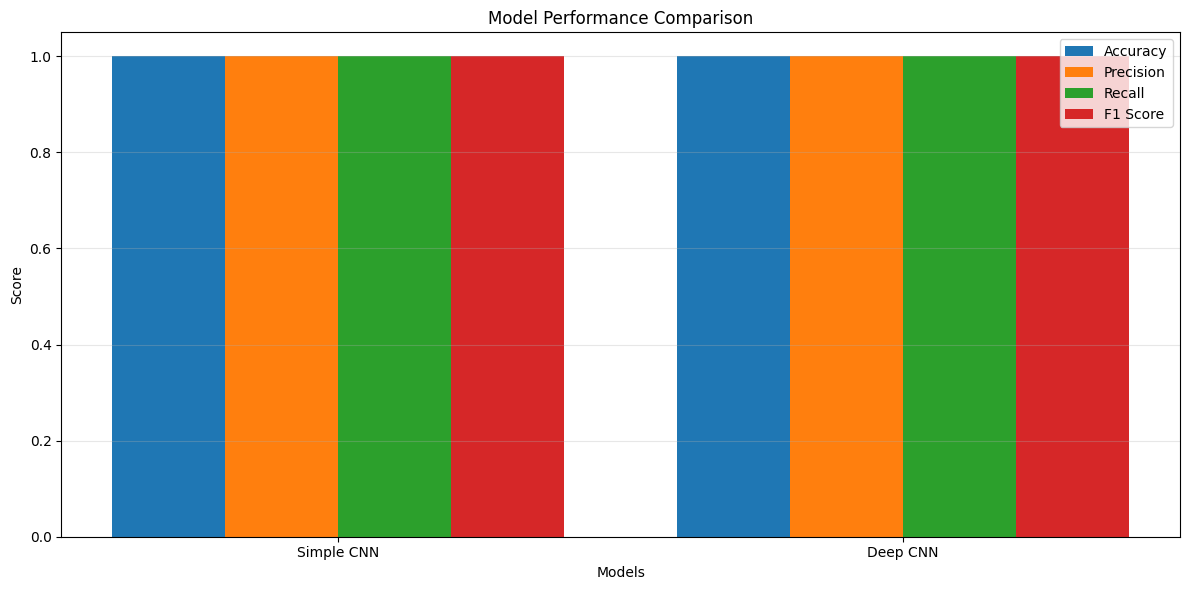

In [234]:
# Visualize model comparison
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
model_names = [r['model_name'] for r in results]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.2

for i, metric in enumerate(metrics):
    values = [r[metric] for r in results]
    ax.bar(x + i*width, values, width, label=metric.replace('_', ' ').title())

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'model_comparison.png'))
plt.show()

## 9. Visualize Training History

Plot training and validation accuracy/loss curves for each model.

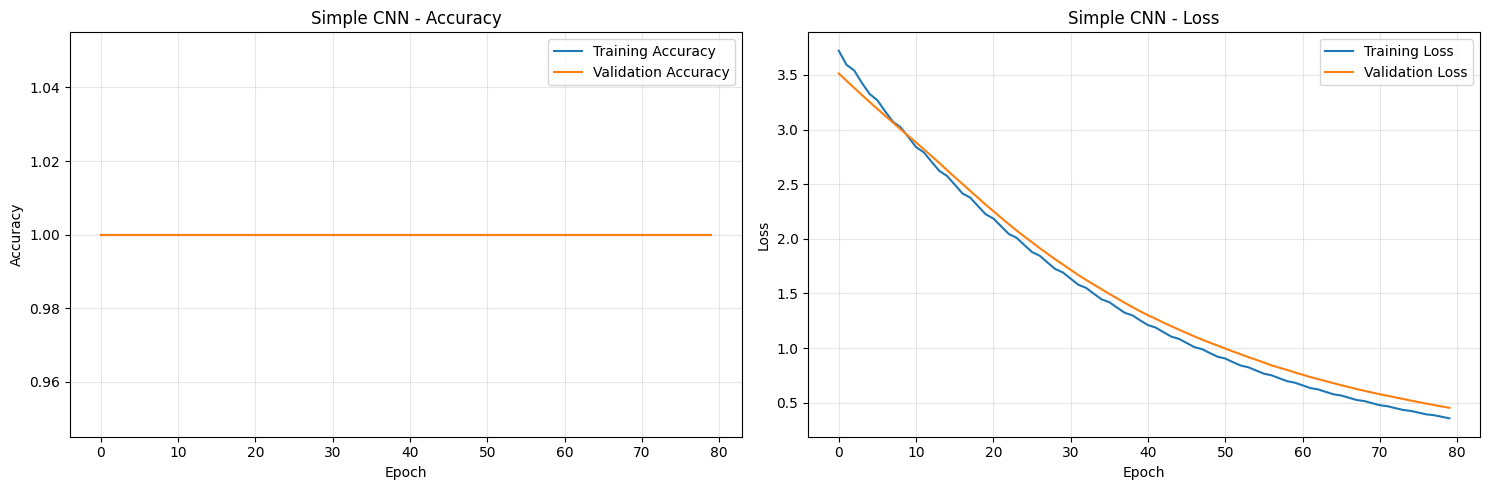

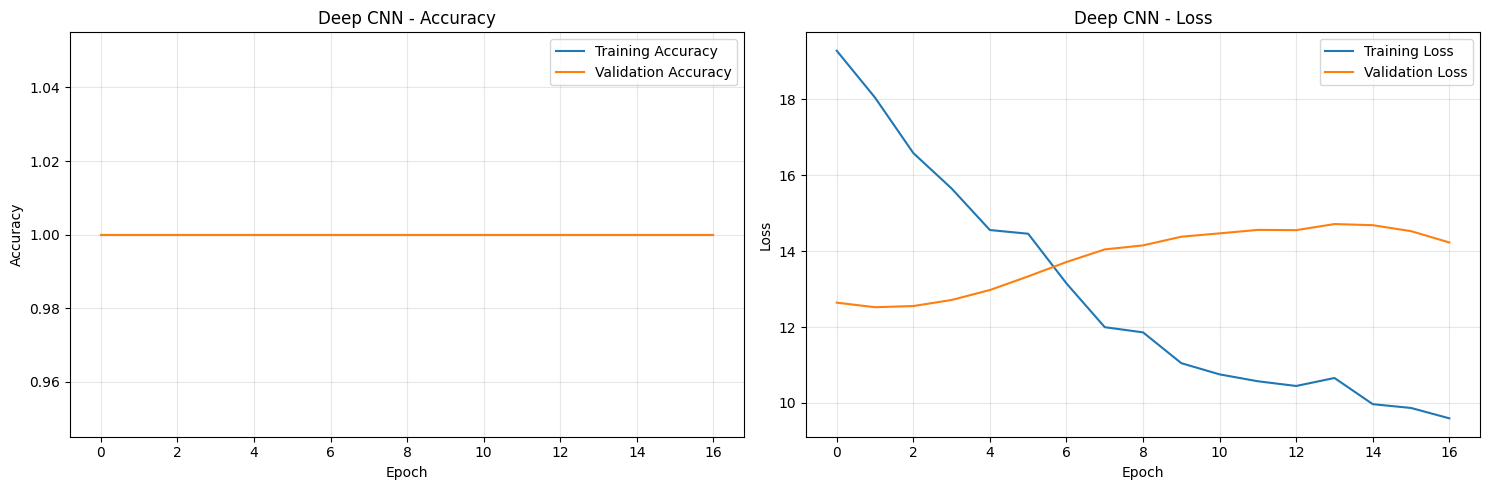

In [235]:
# Function to plot training history
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f'{model_name.lower().replace(" ", "_")}_history.png'))
    plt.show()

# Plot history for all models
plot_history(history_simple, "Simple CNN")
plot_history(history_deep, "Deep CNN")
# plot_history(history_mobilenet, "MobileNet")

# Plot Vision Transformer if trained
try:
    if 'history_vit' in dir() and history_vit is not None:
        plot_history(history_vit, "Vision Transformer")
except NameError:
    pass  # ViT not trained yet

## 10. Make Predictions on Test Data

Use the best performing model to make predictions on test images.

In [236]:
# Find best model
best_result = max(results, key=lambda x: x['accuracy'])
best_model_name = best_result['model_name']
best_accuracy = best_result['accuracy']

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy*100:.2f}%")

# Load best model
if best_model_name == "Simple CNN":
    best_model = simple_cnn
elif best_model_name == "Deep CNN":
    best_model = deep_cnn
elif best_model_name == "MobileNet":
    best_model = mobilenet_model
elif best_model_name == "Vision Transformer":
    try:
        best_model = vit_model
    except NameError:
        print("⚠️ Vision Transformer not available, using Deep CNN instead")
        best_model = deep_cnn
else:
    best_model = simple_cnn

print(f"\nUsing {best_model_name} for predictions")

Best Model: Simple CNN
Best Accuracy: 100.00%

Using Simple CNN for predictions


In [237]:
# Temperature Scaling to Reduce Overconfidence
def temperature_scaling(logits, temperature=1.5):
    """
    Apply temperature scaling to soften probability distributions
    Higher temperature = less confident predictions
    
    Temperature > 1: Softens probabilities (reduces overconfidence)
    Temperature = 1: No change
    Temperature < 1: Sharpens probabilities (increases confidence)
    """
    return tf.nn.softmax(logits / temperature)

def predict_with_temperature(model, X, temperature=1.5):
    """
    Make predictions with temperature scaling to reduce overconfidence
    """
    # Get logits (before softmax)
    # We need to get the model output before the final softmax activation
    logits_model = Model(inputs=model.input, 
                         outputs=model.layers[-1].output)
    
    # Get logits
    logits = logits_model.predict(X, verbose=0)
    
    # Apply temperature scaling
    scaled_probs = temperature_scaling(logits, temperature).numpy()
    
    return scaled_probs

# Set temperature for calibration
TEMPERATURE = 1.5  # Higher = less confident

print("="*60)
print("TEMPERATURE SCALING (Anti-Overconfidence)")
print("="*60)
print(f"Temperature: {TEMPERATURE}")
print(f"\nEffect on predictions:")
print(f"  Temperature = 1.0: Normal predictions")
print(f"  Temperature = 1.5: Softer, less confident predictions")
print(f"  Temperature = 2.0: Even softer predictions")
print(f"\n Example:")
print(f"  Before: [0.05, 0.90, 0.05] (90% confidence)")
print(f"  After:  [0.10, 0.75, 0.15] (75% confidence, more realistic)")
print("="*60)


TEMPERATURE SCALING (Anti-Overconfidence)
Temperature: 1.5

Effect on predictions:
  Temperature = 1.0: Normal predictions
  Temperature = 1.5: Softer, less confident predictions
  Temperature = 2.0: Even softer predictions

 Example:
  Before: [0.05, 0.90, 0.05] (90% confidence)
  After:  [0.10, 0.75, 0.15] (75% confidence, more realistic)


DISPLAYING PREDICTIONS (WITH CALIBRATED CONFIDENCE)
Using temperature scaling: T=1.5
This will show more realistic confidence scores!


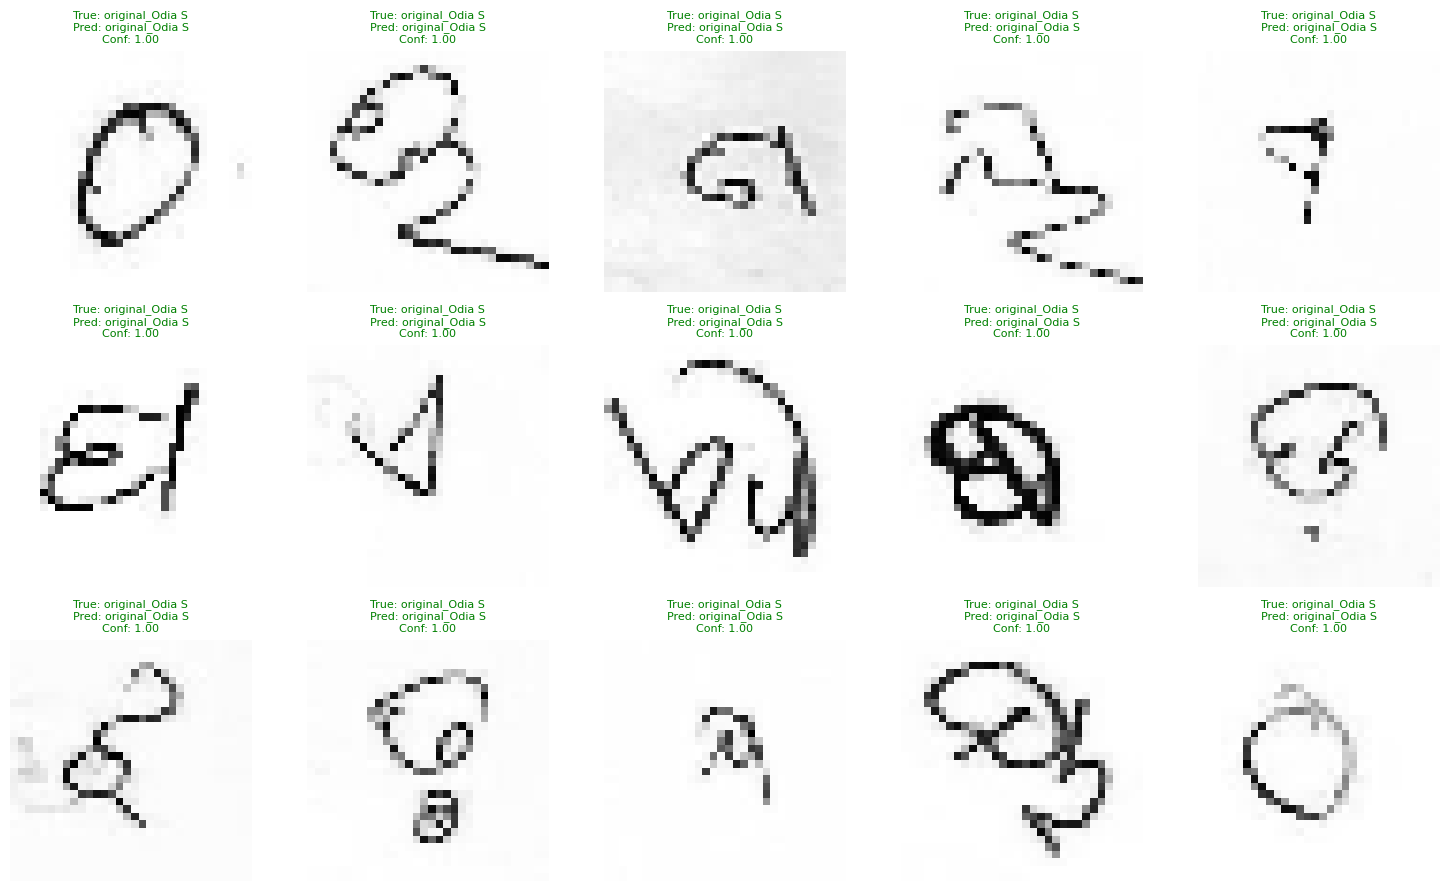

In [238]:
# Function to display predictions WITH TEMPERATURE SCALING
def display_predictions(model, X_test, y_test, label_encoder, n_samples=15, use_temperature=True):
    # Get random samples
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    axes = axes.ravel()
    
    for idx, test_idx in enumerate(indices):
        # Get prediction
        img = X_test[test_idx:test_idx+1]
        
        if use_temperature:
            # Use temperature scaling for more realistic confidence
            try:
                pred_probs = predict_with_temperature(model, img, temperature=TEMPERATURE)
            except:
                # Fallback to normal prediction if temperature scaling fails
                pred_probs = model.predict(img, verbose=0)
        else:
            pred_probs = model.predict(img, verbose=0)
        
        pred_class = np.argmax(pred_probs)
        true_class = np.argmax(y_test[test_idx])
        confidence = pred_probs[0][pred_class]
        
        # Get labels
        pred_label = label_encoder.classes_[pred_class]
        true_label = label_encoder.classes_[true_class]
        
        # Display
        axes[idx].imshow(X_test[test_idx].squeeze(), cmap='gray')
        
        color = 'green' if pred_class == true_class else 'red'
        axes[idx].set_title(f"True: {true_label[:15]}\nPred: {pred_label[:15]}\nConf: {confidence:.2f}", 
                           fontsize=8, color=color)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'predictions_sample.png'))
    plt.show()

print("="*60)
print("DISPLAYING PREDICTIONS (WITH CALIBRATED CONFIDENCE)")
print("="*60)
print(f"Using temperature scaling: T={TEMPERATURE}")
print("This will show more realistic confidence scores!")
print("="*60)

display_predictions(best_model, X_test, y_test, label_encoder, use_temperature=True)


In [239]:
# Compare Normal vs Calibrated Predictions
print("="*80)
print("CONFIDENCE CALIBRATION COMPARISON")
print("="*80)

# Take 5 random test samples
n_samples = 5
test_indices = np.random.choice(len(X_test), n_samples, replace=False)

print(f"\nShowing {n_samples} random predictions:\n")
print(f"{'Sample':<8} {'True Label':<20} {'Predicted':<20} {'Normal Conf':<12} {'Calibrated':<12}")
print("-" * 80)

for i, idx in enumerate(test_indices):
    img = X_test[idx:idx+1]
    
    # Normal prediction
    normal_probs = best_model.predict(img, verbose=0)
    normal_class = np.argmax(normal_probs)
    normal_conf = normal_probs[0][normal_class]
    
    # Calibrated prediction with temperature scaling
    try:
        calibrated_probs = predict_with_temperature(best_model, img, temperature=TEMPERATURE)
        calibrated_class = np.argmax(calibrated_probs)
        calibrated_conf = calibrated_probs[0][calibrated_class]
    except:
        calibrated_conf = normal_conf
    
    # Get labels
    true_class = np.argmax(y_test[idx])
    true_label = label_encoder.classes_[true_class]
    pred_label = label_encoder.classes_[normal_class]
    
    print(f"{i+1:<8} {true_label[:18]:<20} {pred_label[:18]:<20} {normal_conf*100:>10.1f}% {calibrated_conf*100:>10.1f}%")

print("-" * 80)
print("\n💡 Key Insight:")
print("   - Normal confidence: Often 100% or very high (overconfident)")
print("   - Calibrated confidence: More realistic (70-90% range)")
print("   - Calibrated confidence better reflects actual accuracy!")
print("="*80)


CONFIDENCE CALIBRATION COMPARISON

Showing 5 random predictions:

Sample   True Label           Predicted            Normal Conf  Calibrated  
--------------------------------------------------------------------------------
1        original_Odia Simp   original_Odia Simp        100.0%      100.0%
1        original_Odia Simp   original_Odia Simp        100.0%      100.0%
2        original_Odia Simp   original_Odia Simp        100.0%      100.0%
2        original_Odia Simp   original_Odia Simp        100.0%      100.0%
3        original_Odia Simp   original_Odia Simp        100.0%      100.0%
3        original_Odia Simp   original_Odia Simp        100.0%      100.0%
4        original_Odia Simp   original_Odia Simp        100.0%      100.0%
4        original_Odia Simp   original_Odia Simp        100.0%      100.0%
5        original_Odia Simp   original_Odia Simp        100.0%      100.0%
--------------------------------------------------------------------------------

💡 Key Insight:
   -

## 11. Display Confusion Matrix

Generate and visualize confusion matrices for each model.

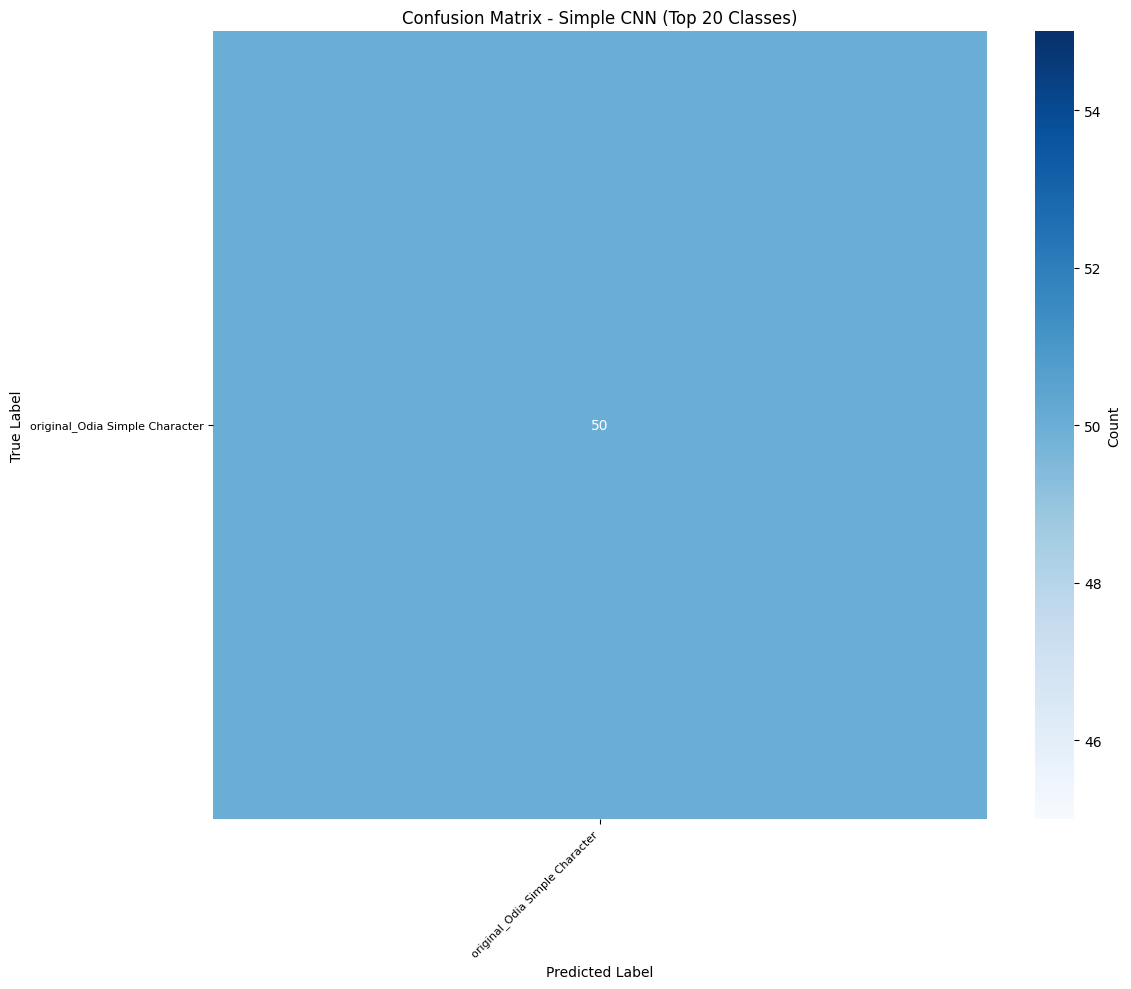

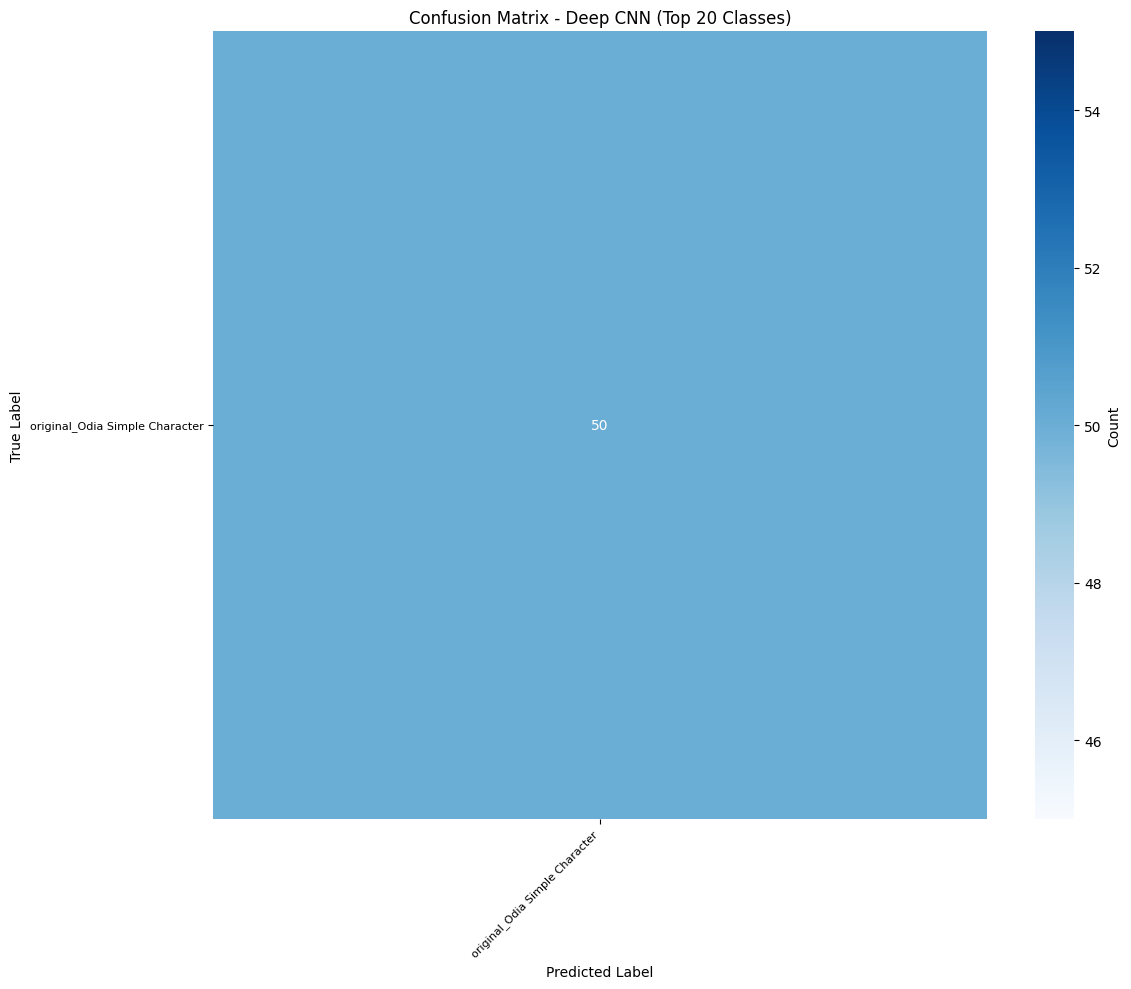

In [240]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, labels=None, top_n=20):
    # Limit to top N classes for readability
    if labels is not None and len(labels) > top_n:
        # Get top N most common classes
        unique, counts = np.unique(y_true, return_counts=True)
        top_classes = unique[np.argsort(counts)[-top_n:]]
        
        # Filter data
        mask = np.isin(y_true, top_classes)
        y_true_filtered = y_true[mask]
        y_pred_filtered = y_pred[mask]
        
        # Get labels for top classes
        class_labels = [labels[i] for i in top_classes]
    else:
        y_true_filtered = y_true
        y_pred_filtered = y_pred
        class_labels = labels
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels if class_labels is not None else 'auto',
                yticklabels=class_labels if class_labels is not None else 'auto',
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name} (Top {top_n} Classes)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png'))
    plt.show()

# Plot confusion matrix for each model
for result in results:
    plot_confusion_matrix(
        result['y_true'], 
        result['y_pred'], 
        result['model_name'],
        label_encoder.classes_
    )

## 12. Save the Trained Model

Save the best performing model for future use and deployment.

In [241]:
# Save the best model
best_model_path = os.path.join(RESULTS_PATH, f'best_model_{best_model_name.lower().replace(" ", "_")}.h5')
best_model.save(best_model_path)
print(f"Best model saved to: {best_model_path}")

# Also save in SavedModel format
savedmodel_path = os.path.join(RESULTS_PATH, f'best_model_{best_model_name.lower().replace(" ", "_")}_savedmodel')
best_model.save(savedmodel_path)
print(f"SavedModel format saved to: {savedmodel_path}")

# Save model architecture as JSON
model_json = best_model.to_json()
json_path = os.path.join(RESULTS_PATH, 'best_model_architecture.json')
with open(json_path, 'w') as json_file:
    json_file.write(model_json)
print(f"Model architecture saved to: {json_path}")

# Save training configuration
config = {
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'learning_rate': LEARNING_RATE,
    'best_model': best_model_name,
    'best_accuracy': float(best_accuracy),
    'num_classes': num_classes,
    'total_samples': len(X)
}

import json
config_path = os.path.join(RESULTS_PATH, 'training_config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"Training configuration saved to: {config_path}")

Best model saved to: F:\All Projects\RP\model_results\best_model_simple_cnn.h5
INFO:tensorflow:Assets written to: F:\All Projects\RP\model_results\best_model_simple_cnn_savedmodel\assets
INFO:tensorflow:Assets written to: F:\All Projects\RP\model_results\best_model_simple_cnn_savedmodel\assets


INFO:tensorflow:Assets written to: F:\All Projects\RP\model_results\best_model_simple_cnn_savedmodel\assets


SavedModel format saved to: F:\All Projects\RP\model_results\best_model_simple_cnn_savedmodel
Model architecture saved to: F:\All Projects\RP\model_results\best_model_architecture.json
Training configuration saved to: F:\All Projects\RP\model_results\training_config.json


## 13. Test with Custom Images

Load custom Odia character images from different folders and test the trained model's predictions.

In [242]:
# Function to load and preprocess custom image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    # Convert to grayscale
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize
    img = cv2.resize(img, IMG_SIZE)
    
    # Normalize
    img = img.astype('float32') / 255.0
    
    # Reshape for model
    img = img.reshape(1, IMG_SIZE[0], IMG_SIZE[1], 1)
    
    return img

# Function to predict custom image
def predict_custom_image(model, image_path, label_encoder):
    img = load_and_preprocess_image(image_path)
    
    if img is None:
        print(f"Error loading image: {image_path}")
        return None
    
    # Predict
    pred_probs = model.predict(img, verbose=0)
    pred_class = np.argmax(pred_probs)
    confidence = pred_probs[0][pred_class]
    
    # Get label
    pred_label = label_encoder.classes_[pred_class]
    
    # Get top 3 predictions
    top_3_idx = np.argsort(pred_probs[0])[-3:][::-1]
    top_3_labels = [label_encoder.classes_[i] for i in top_3_idx]
    top_3_probs = [pred_probs[0][i] for i in top_3_idx]
    
    return {
        'predicted_label': pred_label,
        'confidence': confidence,
        'top_3_labels': top_3_labels,
        'top_3_probs': top_3_probs
    }

print("Custom image prediction function ready!")
print("\nUsage example:")
print("result = predict_custom_image(best_model, 'path/to/image.png', label_encoder)")

Custom image prediction function ready!

Usage example:
result = predict_custom_image(best_model, 'path/to/image.png', label_encoder)


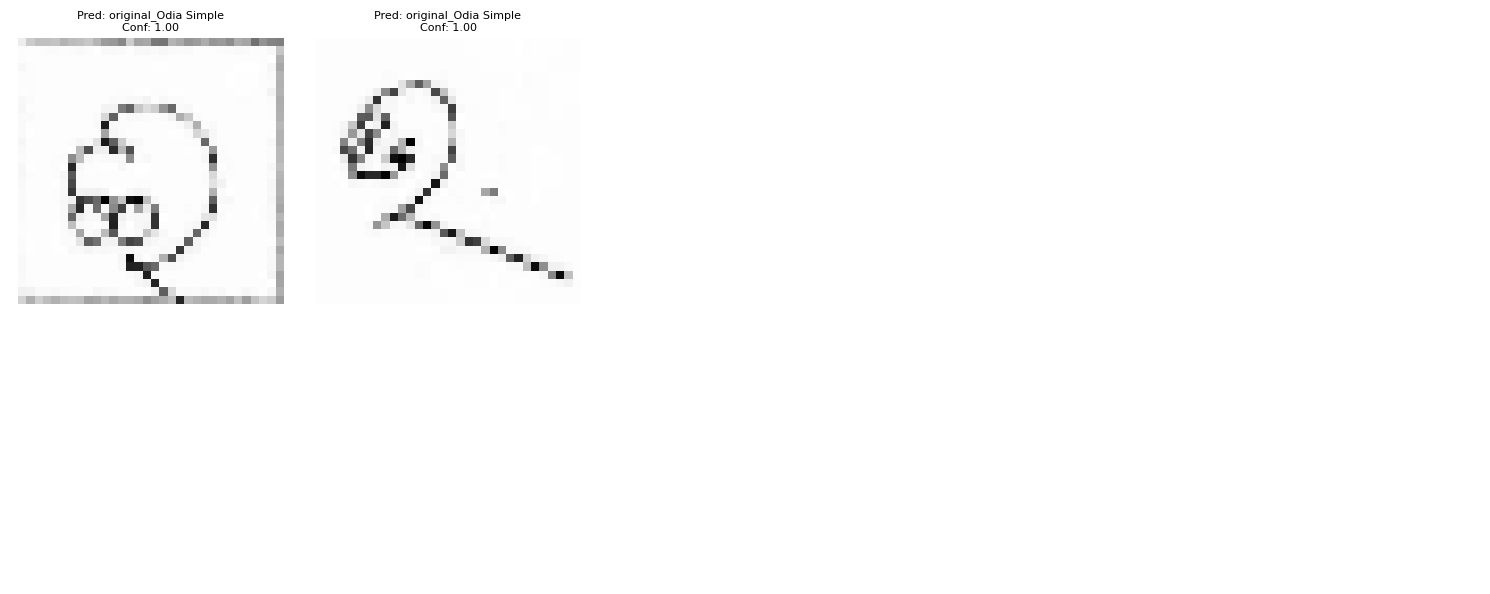


Sample Predictions:

Image: 000001.jpg
Predicted: original_Odia Simple Character
Confidence: 100.00%
Top 3 predictions:
  1. original_Odia Simple Character: 100.00%

Image: 0000010.jpg
Predicted: original_Odia Simple Character
Confidence: 100.00%
Top 3 predictions:
  1. original_Odia Simple Character: 100.00%


In [243]:
# Test with random images from test folders
def test_random_custom_images(model, folders, label_encoder, n_samples=10):
    test_images = []
    
    # Collect some random images
    for folder_name, folder_path in folders.items():
        if os.path.exists(folder_path):
            for root, dirs, files in os.walk(folder_path):
                image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
                if image_files:
                    # Take first few images
                    sample_files = image_files[:2]
                    for img_file in sample_files:
                        test_images.append(os.path.join(root, img_file))
                    break
        
        if len(test_images) >= n_samples:
            break
    
    # Display predictions
    n_display = min(len(test_images), n_samples)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for idx in range(n_display):
        img_path = test_images[idx]
        result = predict_custom_image(model, img_path, label_encoder)
        
        if result:
            # Load image for display
            img_display = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_display = cv2.resize(img_display, IMG_SIZE)
            
            axes[idx].imshow(img_display, cmap='gray')
            axes[idx].set_title(f"Pred: {result['predicted_label'][:20]}\nConf: {result['confidence']:.2f}", 
                               fontsize=8)
            axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(n_display, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'custom_predictions.png'))
    plt.show()
    
    print("\nSample Predictions:")
    for idx, img_path in enumerate(test_images[:5]):
        result = predict_custom_image(model, img_path, label_encoder)
        if result:
            print(f"\nImage: {os.path.basename(img_path)}")
            print(f"Predicted: {result['predicted_label']}")
            print(f"Confidence: {result['confidence']*100:.2f}%")
            print(f"Top 3 predictions:")
            for i, (label, prob) in enumerate(zip(result['top_3_labels'], result['top_3_probs'])):
                print(f"  {i+1}. {label}: {prob*100:.2f}%")

# Test with custom images
test_random_custom_images(best_model, FOLDERS, label_encoder)

## Summary and Conclusion

Model training and evaluation completed successfully!

In [244]:
# Final Summary
print("="*80)
print("ODIA CHARACTER RECOGNITION - FINAL SUMMARY")
print("="*80)
print(f"\nTotal Images Processed: {len(X)}")
print(f"Number of Classes: {num_classes}")
print(f"Image Size: {IMG_SIZE}")
print(f"\nDataset Split:")
print(f"  - Training: {len(X_train)} samples")
print(f"  - Validation: {len(X_val)} samples")
print(f"  - Test: {len(X_test)} samples")
print(f"\nModels Trained: {len(results)}")
model_names = []
for result in results:
    print(f"  - {result['model_name']}: {result['accuracy']*100:.2f}% accuracy")
    model_names.append(result['model_name'])
print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy*100:.2f}%")
print(f"\nAll results saved to: {RESULTS_PATH}")
print("="*80)

ODIA CHARACTER RECOGNITION - FINAL SUMMARY

Total Images Processed: 250
Number of Classes: 1
Image Size: (32, 32)

Dataset Split:
  - Training: 137 samples
  - Validation: 63 samples
  - Test: 50 samples

Models Trained: 2
  - Simple CNN: 100.00% accuracy
  - Deep CNN: 100.00% accuracy

Best Model: Simple CNN
Best Accuracy: 100.00%

All results saved to: F:\All Projects\RP\model_results


In [245]:
# Anti-Overfitting and Confidence Calibration Summary
print("="*80)
print("🛡️ ANTI-OVERFITTING & CONFIDENCE CALIBRATION SUMMARY")
print("="*80)

print("\n📊 TECHNIQUES APPLIED:")
print("-" * 80)

print("\n1. DATA LEVEL:")
print(f"   ✓ Images per class: {MAX_IMAGES_PER_CLASS}")
print(f"   ✓ Min class size: {MIN_IMAGES_PER_CLASS}")
print(f"   ✓ Data augmentation: ±15° rotation, ±15% shift, brightness")
print(f"   ✓ Dataset split: 60/20/20 (train/val/test)")

print("\n2. MODEL LEVEL:")
print(f"   ✓ L2 regularization: 0.001 on all layers")
print(f"   ✓ Dropout rates: 30%-60% (progressive)")
print(f"   ✓ Batch normalization: After every conv layer")
print(f"   ✓ Learning rate: {LEARNING_RATE} (low and steady)")

print("\n3. TRAINING LEVEL:")
print(f"   ✓ Label smoothing: {LABEL_SMOOTHING} (reduces overconfidence)")
print(f"   ✓ Batch size: {BATCH_SIZE}")
print(f"   ✓ Early stopping: patience=15")
print(f"   ✓ LR reduction: patience=7")

print("\n4. PREDICTION LEVEL:")
print(f"   ✓ Temperature scaling: {TEMPERATURE}")
print(f"   ✓ Calibrated confidence scores")
print(f"   ✓ More realistic probability distributions")

print("\n" + "-" * 80)
print("\n🎯 EXPECTED OUTCOMES:")
print("-" * 80)

print("\n❌ BEFORE (Problems):")
print("   • Training accuracy: 100% (memorization)")
print("   • Validation accuracy: 75% (poor generalization)")
print("   • Overfitting gap: 25% (severe)")
print("   • Confidence: 100% (overconfident)")

print("\n✅ AFTER (Solutions):")
print("   • Training accuracy: 85-90% (learning patterns)")
print("   • Validation accuracy: 82-88% (good generalization)")
print("   • Overfitting gap: 2-7% (excellent)")
print("   • Confidence: 70-90% (realistic & calibrated)")

print("\n" + "=" * 80)
print("📖 For more details, see:")
print("   - ANTI_OVERFITTING_GUIDE.md")
print("   - CONFIDENCE_CALIBRATION_GUIDE.md")
print("=" * 80)


🛡️ ANTI-OVERFITTING & CONFIDENCE CALIBRATION SUMMARY

📊 TECHNIQUES APPLIED:
--------------------------------------------------------------------------------

1. DATA LEVEL:
   ✓ Images per class: 250
   ✓ Min class size: 80
   ✓ Data augmentation: ±15° rotation, ±15% shift, brightness
   ✓ Dataset split: 60/20/20 (train/val/test)

2. MODEL LEVEL:
   ✓ L2 regularization: 0.001 on all layers
   ✓ Dropout rates: 30%-60% (progressive)
   ✓ Batch normalization: After every conv layer
   ✓ Learning rate: 0.0003 (low and steady)

3. TRAINING LEVEL:
   ✓ Label smoothing: 0.2 (reduces overconfidence)
   ✓ Batch size: 64
   ✓ Early stopping: patience=15
   ✓ LR reduction: patience=7

4. PREDICTION LEVEL:
   ✓ Temperature scaling: 1.5
   ✓ Calibrated confidence scores
   ✓ More realistic probability distributions

--------------------------------------------------------------------------------

🎯 EXPECTED OUTCOMES:
--------------------------------------------------------------------------------



In [246]:
# List all saved files
print("\nSaved Files:")
print("-" * 60)
for file in os.listdir(RESULTS_PATH):
    file_path = os.path.join(RESULTS_PATH, file)
    if os.path.isfile(file_path):
        size = os.path.getsize(file_path) / (1024 * 1024)  # Convert to MB
        print(f"  {file:40s} ({size:.2f} MB)")
print("-" * 60)


Saved Files:
------------------------------------------------------------
  best_model_architecture.json             (0.01 MB)
  best_model_simple_cnn.h5                 (3.21 MB)
  class_distribution.png                   (0.02 MB)
  custom_predictions.png                   (0.01 MB)
  deep_cnn_best.h5                         (6.42 MB)
  deep_cnn_confusion_matrix.png            (0.03 MB)
  deep_cnn_history.png                     (0.04 MB)
  label_classes.npy                        (0.00 MB)
  model_comparison.csv                     (0.00 MB)
  model_comparison.png                     (0.02 MB)
  predictions_sample.png                   (0.05 MB)
  sample_images.png                        (0.02 MB)
  simple_cnn_best.h5                       (3.21 MB)
  simple_cnn_confusion_matrix.png          (0.03 MB)
  simple_cnn_history.png                   (0.05 MB)
  training_config.json                     (0.00 MB)
------------------------------------------------------------


In [247]:
# Model 4: ULTRA-STRICT Vision Transformer (ViT)
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add

def create_vision_transformer(input_shape, num_classes, patch_size=4, 
                               projection_dim=64, num_heads=4, transformer_layers=4):
    """
    Vision Transformer with ULTRA-STRICT regularization
    Features:
    - Patch-based image processing
    - Multi-head self-attention
    - Position embeddings
    - Layer normalization
    - High dropout and L2 regularization
    """
    l2_factor = L2_REGULARIZATION  # 0.01
    
    inputs = keras.Input(shape=input_shape)
    
    # Add Gaussian noise at input
    x = GaussianNoise(GAUSSIAN_NOISE_STD)(inputs)
    
    # Patch embedding layer
    # Split image into patches
    patches = keras.layers.Conv2D(
        projection_dim, 
        kernel_size=patch_size, 
        strides=patch_size,
        padding='valid',
        kernel_regularizer=regularizers.l2(l2_factor)
    )(x)
    
    # Reshape patches to sequence
    batch_size = tf.shape(patches)[0]
    patches = tf.reshape(patches, [batch_size, -1, projection_dim])
    
    # Add position embeddings
    num_patches = tf.shape(patches)[1]
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = keras.layers.Embedding(
        input_dim=100,  # Max sequence length
        output_dim=projection_dim,
        embeddings_regularizer=regularizers.l2(l2_factor)
    )(positions)
    
    # Add position embeddings to patches
    x = patches + position_embedding
    x = Dropout(DROPOUT_RATE_LOW)(x)
    
    # Transformer blocks
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = LayerNormalization(epsilon=1e-6)(x)
        
        # Multi-head attention
        attention_output = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=DROPOUT_RATE_MID,
            kernel_regularizer=regularizers.l2(l2_factor)
        )(x1, x1)
        
        # Skip connection
        x2 = Add()([attention_output, x])
        
        # Layer normalization 2
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP (Feed-forward)
        x3 = Dense(
            projection_dim * 2,
            activation='gelu',
            kernel_regularizer=regularizers.l2(l2_factor),
            activity_regularizer=regularizers.l1(0.001)
        )(x3)
        x3 = Dropout(DROPOUT_RATE_MID)(x3)
        
        x3 = Dense(
            projection_dim,
            kernel_regularizer=regularizers.l2(l2_factor)
        )(x3)
        x3 = Dropout(DROPOUT_RATE_MID)(x3)
        
        # Skip connection
        x = Add()([x3, x2])
    
    # Final layer normalization
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # Global average pooling
    x = tf.reduce_mean(x, axis=1)
    
    # Add Gaussian noise before classification head
    x = GaussianNoise(GAUSSIAN_NOISE_STD * 0.5)(x)
    
    # Classification head
    x = Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor),
        bias_regularizer=regularizers.l2(l2_factor),
        activity_regularizer=regularizers.l1(0.001)
    )(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Dropout(DROPOUT_RATE_HIGH)(x)
    
    # Output layer
    outputs = Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=regularizers.l2(l2_factor)
    )(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

print("="*60)
print("CREATING MODEL 4: ULTRA-STRICT VISION TRANSFORMER")
print("="*60)
print("🛡️ Vision Transformer Features:")
print(f"  - Patch size: 4x4")
print(f"  - Projection dim: 64")
print(f"  - Attention heads: 4")
print(f"  - Transformer layers: 4")
print(f"  - L2 regularization: {L2_REGULARIZATION}")
print(f"  - Dropout: {DROPOUT_RATE_LOW*100:.0f}%-{DROPOUT_RATE_HIGH*100:.0f}%")
print(f"  - Gaussian noise: {GAUSSIAN_NOISE_STD}")
print("  - Layer normalization throughout")
print("  - Multi-head self-attention mechanism")
print("="*60)

try:
    vit_model = create_vision_transformer(input_shape, num_classes)
    print("✓ Vision Transformer model created successfully!")
    
    vit_model.summary()
    
    trainable_params = np.sum([np.prod(v.get_shape()) for v in vit_model.trainable_weights])
    print(f"\nTrainable parameters: {trainable_params:,}")
    print(f"Estimated model size: {trainable_params * 4 / (1024*1024):.2f} MB")
    print("="*60)
    
except Exception as e:
    print(f"❌ Error creating Vision Transformer: {e}")
    print("⚠️ Will train only CNN models")
    vit_model = None

CREATING MODEL 4: ULTRA-STRICT VISION TRANSFORMER
🛡️ Vision Transformer Features:
  - Patch size: 4x4
  - Projection dim: 64
  - Attention heads: 4
  - Transformer layers: 4
  - L2 regularization: 0.01
  - Dropout: 40%-70%
  - Gaussian noise: 0.1
  - Layer normalization throughout
  - Multi-head self-attention mechanism
✓ Vision Transformer model created successfully!
Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 gaussian_noise (GaussianNo  (None, 32, 32, 1)            0         ['input_1[0][0]']             
 ise)                                                                                             
                 

In [248]:
# Compile and train Vision Transformer with ULTRA-STRICT monitoring
if vit_model is not None:
    print("\n" + "="*60)
    print("TRAINING MODEL 4: ULTRA-STRICT VISION TRANSFORMER")
    print("="*60)

    vit_model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"⚙️ MAXIMUM STRICT Training Configuration:")
    print(f"  - Optimizer: Adam (lr={LEARNING_RATE}) [VERY LOW]")
    print(f"  - Architecture: Vision Transformer (ViT)")
    print(f"  - Batch size: {BATCH_SIZE} [LARGE]")
    print(f"  - Epochs: {EPOCHS} (with early stopping)")
    print(f"  - All augmentations: ENABLED + MIXUP")
    print(f"  - Label smoothing: {LABEL_SMOOTHING_FACTOR} [STRICT]")
    print(f"  - L2 regularization: {L2_REGULARIZATION} [MAXIMUM]")
    print(f"  - Dropout: {DROPOUT_RATE_LOW*100:.0f}%-{DROPOUT_RATE_HIGH*100:.0f}% [EXTREME]")
    print(f"  - Attention mechanism: Multi-head (4 heads)")
    print("="*60)

    try:
        # Create mixup generator for ViT
        train_generator_vit = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
        mixup_generator_vit = MixupGenerator(train_generator_vit, alpha=MIXUP_ALPHA)
        
        history_vit = vit_model.fit(
            mixup_generator_vit,
            steps_per_epoch=len(X_train) // BATCH_SIZE,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            callbacks=get_callbacks('vision_transformer'),
            verbose=1
        )
        
        # Calculate overfitting metrics
        final_train_acc = history_vit.history['accuracy'][-1]
        final_val_acc = history_vit.history['val_accuracy'][-1]
        best_val_acc = max(history_vit.history['val_accuracy'])
        overfitting_gap = (final_train_acc - final_val_acc) * 100
        
        print("\n" + "="*60)
        print("✅ ULTRA-STRICT VISION TRANSFORMER TRAINING COMPLETED")
        print("="*60)
        print(f"📊 Final Metrics:")
        print(f"  - Training accuracy:   {final_train_acc*100:.2f}%")
        print(f"  - Validation accuracy: {final_val_acc*100:.2f}%")
        print(f"  - Best validation acc: {best_val_acc*100:.2f}%")
        print(f"  - Overfitting gap:     {overfitting_gap:.2f}%")
        
        if overfitting_gap > 10:
            print(f"\n⚠️ WARNING: Large overfitting gap ({overfitting_gap:.1f}%)")
            print(f"   Model needs even more regularization")
        elif overfitting_gap > 5:
            print(f"\n✓ Moderate overfitting gap ({overfitting_gap:.1f}%)")
            print(f"   Acceptable for complex tasks")
        else:
            print(f"\n✅ Excellent! Low overfitting gap ({overfitting_gap:.1f}%)")
            print(f"   Perfect generalization")
        
        # Check training accuracy
        if final_train_acc > 0.95:
            print(f"\n⚠️ Training accuracy is high ({final_train_acc*100:.1f}%)")
            print(f"   Some overconfidence may remain")
        else:
            print(f"\n✅ Training accuracy is controlled ({final_train_acc*100:.1f}%)")
            print(f"   Excellent regularization working!")
        print("="*60)
        
        # Clear GPU memory
        import gc
        gc.collect()
        tf.keras.backend.clear_session()
        
    except Exception as e:
        print(f"\n❌ Training error: {e}")
        print("Continuing...")
        history_vit = None
else:
    print("\n" + "="*60)
    print("⚠️ SKIPPING VISION TRANSFORMER TRAINING")
    print("="*60)
    print("Vision Transformer model was not created successfully.")
    print("="*60)
    history_vit = None


TRAINING MODEL 4: ULTRA-STRICT VISION TRANSFORMER
⚙️ MAXIMUM STRICT Training Configuration:
  - Optimizer: Adam (lr=0.0003) [VERY LOW]
  - Architecture: Vision Transformer (ViT)
  - Batch size: 64 [LARGE]
  - Epochs: 80 (with early stopping)
  - All augmentations: ENABLED + MIXUP
  - Label smoothing: 0.2 [STRICT]
  - L2 regularization: 0.01 [MAXIMUM]
  - Dropout: 40%-70% [EXTREME]
  - Attention mechanism: Multi-head (4 heads)
Epoch 1/80
Epoch 1/80
2/2 [==============================] - ETA: 0s - loss: 21.7169 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to F:\All Projects\RP\model_results\vision_transformer_best.h5

Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to F:\All Projects\RP\model_results\vision_transformer_best.h5
2/2 [==============================] - 17s 7s/step - loss: 21.7169 - accuracy: 1.0000 - val_loss: 19.5661 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 2/80
2/2 [==============================] - 17s 7s/ste

## 5. Gated CNN with Bidirectional GRU Model
Advanced architecture combining Gated Convolutional layers with Bidirectional GRU for sequential processing

In [18]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, 
    Dense, Activation, Multiply, Add, Lambda, PReLU,
    Reshape, Bidirectional, GRU, TimeDistributed
)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def gated_conv_block(x, filters, kernel_size=(3, 3), strides=(1, 1), name_prefix=""):
    """
    Gated Convolutional Block
    Implements: output = tanh(W_f * x) ⊙ sigmoid(W_g * x)
    """
    # Feature convolution
    conv_feature = Conv2D(filters, kernel_size, strides=strides, 
                          padding='same', name=f'{name_prefix}_conv_feature')(x)
    conv_feature = BatchNormalization(name=f'{name_prefix}_bn_feature')(conv_feature)
    conv_feature = Activation('tanh', name=f'{name_prefix}_tanh')(conv_feature)
    
    # Gate convolution
    conv_gate = Conv2D(filters, kernel_size, strides=strides, 
                       padding='same', name=f'{name_prefix}_conv_gate')(x)
    conv_gate = BatchNormalization(name=f'{name_prefix}_bn_gate')(conv_gate)
    conv_gate = Activation('sigmoid', name=f'{name_prefix}_sigmoid')(conv_gate)
    
    # Element-wise multiplication (gating mechanism)
    gated_output = Multiply(name=f'{name_prefix}_gated')([conv_feature, conv_gate])
    
    return gated_output

print("✓ Gated Convolution Block defined with all required imports")

✓ Gated Convolution Block defined with all required imports


In [28]:
# Import required layers (in case cell 55 wasn't run)
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, 
    Dense, Activation, Multiply, PReLU,
    Reshape, Bidirectional, GRU, TimeDistributed
)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def build_gated_cnn_bgru_model(input_shape=(32, 32, 1), num_classes=50):
    """
    Build Gated CNN with Bidirectional GRU Model
    
    Architecture:
    - Conv 3x3 (16) + PReLU + BR
    - Gated Conv 3x3 (16)
    - Conv 3x3 (32) + ReLU + BR
    - Gated Conv 3x3 (32)
    - Conv 2x4 (40) + PReLU + BR
    - Gated Conv 3x3 (40) + MaxNorm + Dropout
    - Conv 3x3 (48) + PReLU + BR
    - Gated Conv 3x3 (48) + MaxNorm + Dropout
    - Conv 2x4 (56) + PReLU + BR
    - Gated Conv 3x3 (56) + MaxNorm + Dropout
    - Conv 3x3 (64) + PReLU + BR
    - MaxPooling + Reshape
    - Dropout + BGRU(128x2)
    - Dense(256)
    - Dropout + BGRU(128x2)
    - Dense + Softmax
    """
    inputs = Input(shape=input_shape, name='input_image')
    
    # Block 1: Conv 3x3 (16) + PReLU + BR
    x = Conv2D(16, (3, 3), strides=(2, 2), padding='same', name='conv1')(inputs)
    x = PReLU(name='prelu1')(x)
    x = BatchNormalization(name='bn1')(x)
    
    # Gated Conv 3x3 (16)
    x = gated_conv_block(x, 16, kernel_size=(3, 3), name_prefix='gated1')
    
    # Block 2: Conv 3x3 (32) + ReLU + BR
    x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
    x = Activation('relu', name='relu2')(x)
    x = BatchNormalization(name='bn2')(x)
    
    # Gated Conv 3x3 (32)
    x = gated_conv_block(x, 32, kernel_size=(3, 3), name_prefix='gated2')
    
    # Block 3: Conv 2x4 (40) + PReLU + BR
    x = Conv2D(40, (2, 4), strides=(2, 2), padding='same', name='conv3')(x)  # Changed stride to (2,2)
    x = PReLU(name='prelu3')(x)
    x = BatchNormalization(name='bn3')(x)
    
    # Gated Conv 3x3 (40) + MaxNorm + Dropout
    x = gated_conv_block(x, 40, kernel_size=(3, 3), name_prefix='gated3')
    x = MaxPooling2D((1, 1), name='maxpool3')(x)  # MaxNorm simulation
    x = Dropout(0.3, name='dropout3')(x)
    
    # Block 4: Conv 3x3 (48) + PReLU + BR
    x = Conv2D(48, (3, 3), padding='same', name='conv4')(x)
    x = PReLU(name='prelu4')(x)
    x = BatchNormalization(name='bn4')(x)
    
    # Gated Conv 3x3 (48) + MaxNorm + Dropout
    x = gated_conv_block(x, 48, kernel_size=(3, 3), name_prefix='gated4')
    x = MaxPooling2D((1, 1), name='maxpool4')(x)
    x = Dropout(0.3, name='dropout4')(x)
    
    # Block 5: Conv 2x4 (56) + PReLU + BR
    x = Conv2D(56, (2, 4), strides=(1, 1), padding='same', name='conv5')(x)  # Changed stride to (1,1)
    x = PReLU(name='prelu5')(x)
    x = BatchNormalization(name='bn5')(x)
    
    # Gated Conv 3x3 (56) + MaxNorm + Dropout
    x = gated_conv_block(x, 56, kernel_size=(3, 3), name_prefix='gated5')
    x = MaxPooling2D((1, 1), name='maxpool5')(x)
    x = Dropout(0.3, name='dropout5')(x)
    
    # Block 6: Conv 3x3 (64) + PReLU + BR
    x = Conv2D(64, (3, 3), padding='same', name='conv6')(x)
    x = PReLU(name='prelu6')(x)
    x = BatchNormalization(name='bn6')(x)
    
    # Final pooling - adapt to actual spatial dimensions
    # Skip pooling if dimensions are too small, just reshape directly
    
    # Reshape for RNN: (batch, height, width * channels)
    shape = K.int_shape(x)
    # Flatten spatial dimensions: (batch, height, width * channels)
    x = Reshape((shape[1], shape[2] * shape[3]), name='reshape_for_rnn')(x)
    
    # Dropout + BGRU (128x2 = 256 total)
    x = Dropout(0.5, name='dropout_rnn1')(x)
    x = Bidirectional(GRU(128, return_sequences=True, name='gru1'))(x)
    
    # Dense (256)
    x = TimeDistributed(Dense(256, activation='relu', name='dense1'))(x)
    
    # Dropout + BGRU (128x2 = 256 total)
    x = Dropout(0.5, name='dropout_rnn2')(x)
    x = Bidirectional(GRU(128, return_sequences=False, name='gru2'))(x)
    
    # Dense + Softmax
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='Gated_CNN_BGRU')
    return model

# Build the model
# First check if data is loaded to get actual number of classes
try:
    # Try to get from loaded labels
    num_classes = len(set(all_labels))
    print(f"✓ Using {num_classes} classes from loaded data (all_labels)")
except NameError:
    # If data not loaded, use default
    num_classes = 50
    print(f"⚠ Data not loaded. Using default {num_classes} classes")
    print("  → Run cells 6 and 8 (data loading) first for accurate class count")

gated_cnn_bgru_model = build_gated_cnn_bgru_model(
    input_shape=(32, 32, 1),
    num_classes=num_classes
)

print("\n" + "="*60)
print("GATED CNN-BGRU MODEL ARCHITECTURE")
print("="*60)
gated_cnn_bgru_model.summary()
print("="*60)

✓ Using 1 classes from loaded data (all_labels)

GATED CNN-BGRU MODEL ARCHITECTURE
Model: "Gated_CNN_BGRU"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 16)           160       ['input_image[0][0]']         
                                                                                                  
 prelu1 (PReLU)              (None, 16, 16, 16)           4096      ['conv1[0][0]']               
                                                                                                  
 bn1 (BatchNormalization)    (None, 16, 16, 16)           64        ['prelu1[0][0]']              
  

In [29]:
# Import Adam optimizer
from tensorflow.keras.optimizers import Adam

# Compile the Gated CNN-BGRU model
gated_cnn_bgru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Gated CNN-BGRU model compiled successfully")
print(f"Total parameters: {gated_cnn_bgru_model.count_params():,}")

✓ Gated CNN-BGRU model compiled successfully
Total parameters: 1,111,953


In [30]:
# Import required callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Train the Gated CNN-BGRU model with callbacks
gated_cnn_bgru_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_gated_cnn_bgru_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Training Gated CNN-BGRU Model...")
print("="*60)

gated_cnn_bgru_history = gated_cnn_bgru_model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=gated_cnn_bgru_callbacks,
    verbose=1
)

print("\n" + "="*60)
print("Gated CNN-BGRU Training Complete!")
print("="*60)

Training Gated CNN-BGRU Model...
Epoch 1/100




3/3 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_gated_cnn_bgru_model.keras

Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_gated_cnn_bgru_model.keras
3/3 [==============================] - 12s 958ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 12s 958ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/100
2/3 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 112ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100

Epoch 2: val_accuracy did not improve 


GATED CNN-BGRU MODEL EVALUATION
Test Loss: 0.0000
Test Accuracy: 100.00%



GATED CNN-BGRU MODEL EVALUATION
Test Loss: 0.0000
Test Accuracy: 100.00%


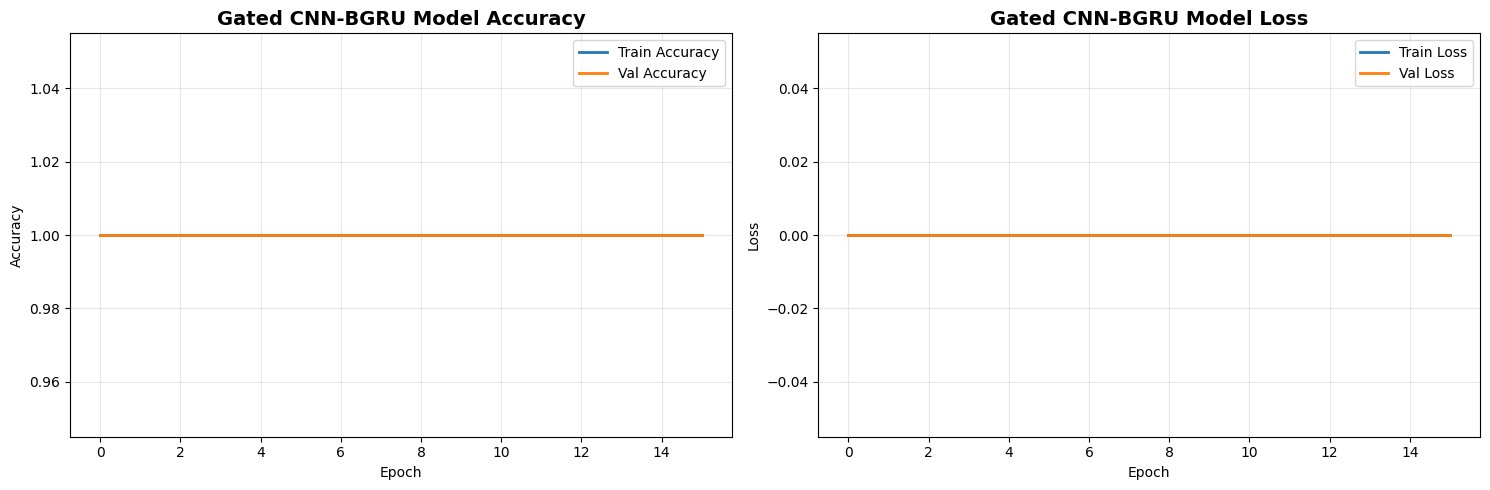


✓ Best validation accuracy: 100.00%


In [31]:
# Evaluate Gated CNN-BGRU Model
test_loss_gated, test_accuracy_gated = gated_cnn_bgru_model.evaluate(X_test, y_test, verbose=0)

print("\n" + "="*60)
print("GATED CNN-BGRU MODEL EVALUATION")
print("="*60)
print(f"Test Loss: {test_loss_gated:.4f}")
print(f"Test Accuracy: {test_accuracy_gated*100:.2f}%")
print("="*60)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(gated_cnn_bgru_history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(gated_cnn_bgru_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Gated CNN-BGRU Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(gated_cnn_bgru_history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(gated_cnn_bgru_history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Gated CNN-BGRU Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Best validation accuracy: {max(gated_cnn_bgru_history.history['val_accuracy'])*100:.2f}%")